In [120]:
# Getting the necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from skimpy import skim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from summarytools import dfSummary
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error


# Data Source:
https://ec.europa.eu/eurostat/databrowser/view/avia_paocc/default/table?lang=en&category=avia.avia_pa.avia_pao

# Towards Data Science Article Link for Time Series: 
https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6/

## Meaning of some columns
### The tra_meas column categorizes the passenger data as follows:

#### tra_meas Values
* Passengers carried: Total number of passengers transported by air, regardless of whether they are arriving or departing. This is the total passenger count for flights associated with Germany (e.g., flights to/from/within Germany). In your dataset, there are 277 entries with this measurement.

* Passengers carried (arrivals): Number of passengers who arrived in Germany on flights. This counts passengers disembarking in Germany (e.g., at German airports like Frankfurt or Munich). There are 277 entries for this.

* Passengers carried (departures): Number of passengers who departed from Germany on flights. This counts passengers boarding flights leaving Germany. There are 277 entries for this.

* Passengers on board: Total number of passengers on board flights associated with Germany, regardless of arrival or departure. This might overlap with "Passengers carried" but could reflect a slightly different reporting metric (e.g., passengers on flights operated by German carriers). There are 277 entries for this.

* Passengers on board (arrivals): Number of passengers on board flights arriving in Germany. This is similar to "Passengers carried (arrivals)" but might reflect passengers on the flight rather than those who disembark (e.g., including transit passengers). There are 277 entries for this.

* Passengers on board (departures): Number of passengers on board flights departing from Germany. Similar to "Passengers carried (departures)" but might include transit passengers. There are 277 entries for this.

* unit
* tra_cov
* geo: Location of where the passengers are landing and leaving from
* TIME_PERIOD: Which year and month we are referring to with for Germany starting from 2002-January-01 to 2025-May
* Total_Passengers: # of Passengers boarding and departing in and out of Germany
* EMA_0.3: Estimated Moving Average with a specific alpha value (0.3)
* EMA_0.8: Estimated Moving Average with a specific alpha value (0.8)
* EMA_0.7: Estimated Moving Average with a specific alpha value (0.7) 
* EMA_0.75: Estimated Moving Average with a specific alpha value (0.75)
* Rolling_window2: Another moving average with rolling windows 2

In [2]:
# Reading the dataset

air = pd.read_csv('dataset/airpassenger.csv')

In [3]:
# Seeing what type of data we are dealing with

air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54555 entries, 0 to 54554
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     54555 non-null  object 
 1   LAST UPDATE  54555 non-null  object 
 2   freq         54555 non-null  object 
 3   unit         54555 non-null  object 
 4   tra_meas     54555 non-null  object 
 5   tra_cov      54555 non-null  object 
 6   schedule     54555 non-null  object 
 7   geo          54555 non-null  object 
 8   TIME_PERIOD  54555 non-null  object 
 9   OBS_VALUE    54555 non-null  int64  
 10  OBS_FLAG     0 non-null      float64
 11  CONF_STATUS  0 non-null      float64
dtypes: float64(2), int64(1), object(9)
memory usage: 5.0+ MB


In [4]:
# Converting the Time_Period column into datetime type

air['TIME_PERIOD'] = pd.to_datetime(air['TIME_PERIOD'])

In [5]:
# Confirm if it worked

air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54555 entries, 0 to 54554
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATAFLOW     54555 non-null  object        
 1   LAST UPDATE  54555 non-null  object        
 2   freq         54555 non-null  object        
 3   unit         54555 non-null  object        
 4   tra_meas     54555 non-null  object        
 5   tra_cov      54555 non-null  object        
 6   schedule     54555 non-null  object        
 7   geo          54555 non-null  object        
 8   TIME_PERIOD  54555 non-null  datetime64[ns]
 9   OBS_VALUE    54555 non-null  int64         
 10  OBS_FLAG     0 non-null      float64       
 11  CONF_STATUS  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 5.0+ MB


In [6]:
# Setting the date column as index for easier plotting

air = air.set_index(air['TIME_PERIOD'])

In [7]:
# Making sure the index is sorted for no errors when plotting

air = air.sort_index()

In [8]:
# Making sure the data represents the passengers travelling from Germany and not any other country

air_germany = air[air['geo'] == 'Germany']

In [9]:
#Double check if it works

air_germany.head(10)

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,tra_cov,schedule,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
TIME_PERIOD,,,,,,,,,,,,
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (arrival),Total transport,Total,Germany,2002-01-01,4287851,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Germany,2002-01-01,7044282,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried,Total transport,Total,Germany,2002-01-01,6875419,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (departures),Total transport,Total,Germany,2002-01-01,4189696,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (departures),Total transport,Total,Germany,2002-01-01,4086737,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (arrivals),Total transport,Total,Germany,2002-01-01,4423072,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (arrival),Total transport,Total,Germany,2002-02-01,4281142,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (arrivals),Total transport,Total,Germany,2002-02-01,4408669,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (departures),Total transport,Total,Germany,2002-02-01,4489250,NaN,NaN


In [10]:
air_germany.index.max()

Timestamp('2025-01-01 00:00:00')

In [11]:
# Cleaning the dataset and making a new variable out of it

ag_cleaned = air_germany.drop(labels=['DATAFLOW', 'freq', 'schedule',
                         'OBS_FLAG',
                         'CONF_STATUS',
                         'LAST UPDATE'],
                 axis = 1)

In [12]:
# Renaming OBS_VALUE to total_passengers for clarity

ag_cleaned.rename({'OBS_VALUE': 'Total_Passengers'}, axis  = 1, inplace=True)

In [13]:
# Checking columns of what they are about

ag_cleaned['tra_meas'].value_counts()

tra_meas
Passengers carried (arrival)        277
Passengers on board                 277
Passengers carried                  277
Passengers on board (departures)    277
Passengers carried (departures)     277
Passengers on board (arrivals)      277
Name: count, dtype: int64

In [14]:
# Making sure we get "Passengers on board" which is cummulation of the number of everyone who went in and out of Germany

ob_cleaned = ag_cleaned[ag_cleaned['tra_meas'] == 'Passengers on board']

In [15]:
# More data exploration using the skim library

skim(ob_cleaned)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 277    │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 6      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name ┃ NA ┃ NA % ┃ mean     ┃ sd      ┃ p0     ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Total_Passe │  0 │    0 │ 13780000 │ 4530000 │ 274300 │ 11230000 │ 13820000 │ 16900000 │ 22910000 │ ▁▁▆▇▇▃ │  │
│ │ ngers       │    │      │          │         │        │          │          │          │          │        │  │
│ └─────────────┴────┴──────┴──────────┴─────────┴────────┴──────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ TIME_PERIOD            │      0 │         0 │     2002-01-01      │     2025-01-01      │ MS               │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ unit                      │       0 │          0 │                            1 │                      277 │  │
│ │ tra_meas                  │       0 │          0 │                            3 │                      831 │  │
│ │ tra_cov                   │       0 │          0 │                            2 │                      554 │  │
│ │ geo                       │       0 │          0 │                            1 │                      277 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [16]:
# More exploration

dfSummary(ob_cleaned)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,unit[object],1. Passenger,277 (100.0%),,0(0.0%)
2,tra_meas[object],1. Passengers on board,277 (100.0%),,0(0.0%)
3,tra_cov[object],1. Total transport,277 (100.0%),,0(0.0%)
4,geo[object],1. Germany,277 (100.0%),,0(0.0%)
5,TIME_PERIOD[datetime64[ns]],"Min: 2002-01-01Max: 2025-01-01Duration: 8,401 days",277 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQklEQVR4nO3YvY7aQBSG4TPAggHLFmJjOpqUkVK49EXkYnMJQeIKKNJsRYdkIVs4izCO02SlFOHHK+3ndfI+rRnP0fAOBa6uawMUem0PgP8HsUFmcO2hc25sZsNXvLdnZj9fse5U1/Vz00UtzGmmn7UrZ3NxzouxOefG8/n8SxAEsyY7VVX1UBTFR9/3n3q9XtlkbZ7ne+fc1yaH2sac6lnV+73Vd3jtl20YBMEsSZLnMAyP92623W5nm83mQxzH3xeLxf7edVmWeavVKkrT9NE5l9+7zswC3/ejJElyxZxtzNqVs8myzFuv17M0TYdm1ig2MzMLw/AYRdGPezfc7/djM7PpdNpoXVEUD2VZfl4ul/1+v3/3wZRl6VVV9Wk0Gn1TzNnGrF06GzMbX3pwMzaV0+k08DxvEsfxsclt+n0LJ+fzuf+W8/1JPWuXzuaadxPbi6a36eUWtkE9a5fO5m/46wMyxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDzODWB7Is85q88HA4eGZmRVF4u91u8q+t69Ks6nW3WvkFbBFstpFl4sYAAAAASUVORK5CYII="">",0(0.0%)
6,Total_Passengers[int64],Mean (sd) : 13777159.8 (4530394.5)min < med < max:274314.0 < 13820925.0 < 22907255.0IQR (CV) : 5669250.0 (3.0),277 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACv0lEQVR4nO3dT27aQBSA8TclgPkjI4QEOy5QqQuWPkQP2yNkkRNwA3ZICBnhxsIYd5WKtGmCZ+wwb/r99gYvPjn2G+IxVVUJ4Lsv9z4B4BYP9z6BEBljBiLSszz8VFXVc5PnEwJCbZgxZjCbzb7HcTy1Of5wOOyNMT+I9TVCbV4vjuNpkiTPk8kkr3NgmqbR09PTdLfb9USEUK8Qaksmk0k+n89/Whw6aPxkAsDDFFQgVKhAqFCBe1TPlGXZFZHYGGP7EUGOtwjVI1mWdYui+LZcLjudTqfWxOBFqOMtQvXI6XR6iKJouFqt8sVisa97fMjjLUL9B4fVpfhyuXRdvns0GtmOtkQCHW8R6htcVpeKoojKsvya5/mjiNjGhj8Q6tusV5c2m810vV4Pz+dzp62T+x8R6jtsVpf2+/1d//Q6Tg28nRgQakBcpwY+TwwINSAuUwPfJwaEGiCHqYG3EwOWUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVOBnfvjN53cKECpExP93ChAqRMT/dwoQKl7x9Z0CPExBBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQI9tdTDruaiDSwswmaFWSoLruaiLCziY+CDFUcdjURYWcTH4UaqojY7Woicv+dTfC3oEPF52pz6yBCRSPa3jqIUNGItrcOIlQ0qq2tgz4M1XEe6e2WhdDl3VBd55E+b1kIXT66olrPI33fshC63HSPajuPFI+3LIQuXj9MOdwfs1YfGG9Ddbk/Zq0+PK2G6rhSEY/H43mSJIe698es1YentVBdVyperor9fv+x7v0xa/XhaS1U19cYclXEtdbvUW1XKrgq4hr/igIVbrqipmka1f3g4/EYiYhkWRZtt9vhZx6v9bu1nrfr8bf09QvZ+7TZm/YH4AAAAABJRU5ErkJggg=="">",0(0.0%)


In [17]:
# ag_cleaned['tra_meas'].value_counts()

[Text(0.5, 1.0, 'Time Series of Travel in Germany (2002 - 2024)'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of passengers')]

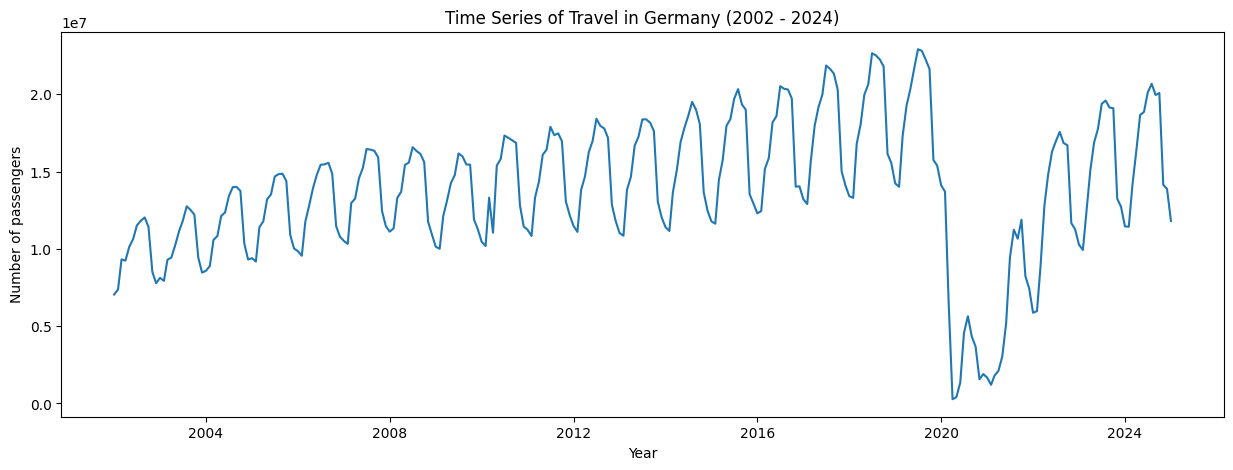

In [18]:
# Exploring the dataset on trend and seasonality

index = ob_cleaned['Total_Passengers'].loc['2002-01-01' : '2025-01-01'].index
data = ob_cleaned['Total_Passengers'].loc['2002-01-01' : ' 2025-01-01']
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(index, data)
ax.set(title = 'Time Series of Travel in Germany (2002 - 2024)', xlabel='Year', ylabel = 'Number of passengers')
# ag_cleaned.loc['2022': '2024']['Total_Passengers'].plot(figsize=(15, 5), xlim=['2022', '2024'])

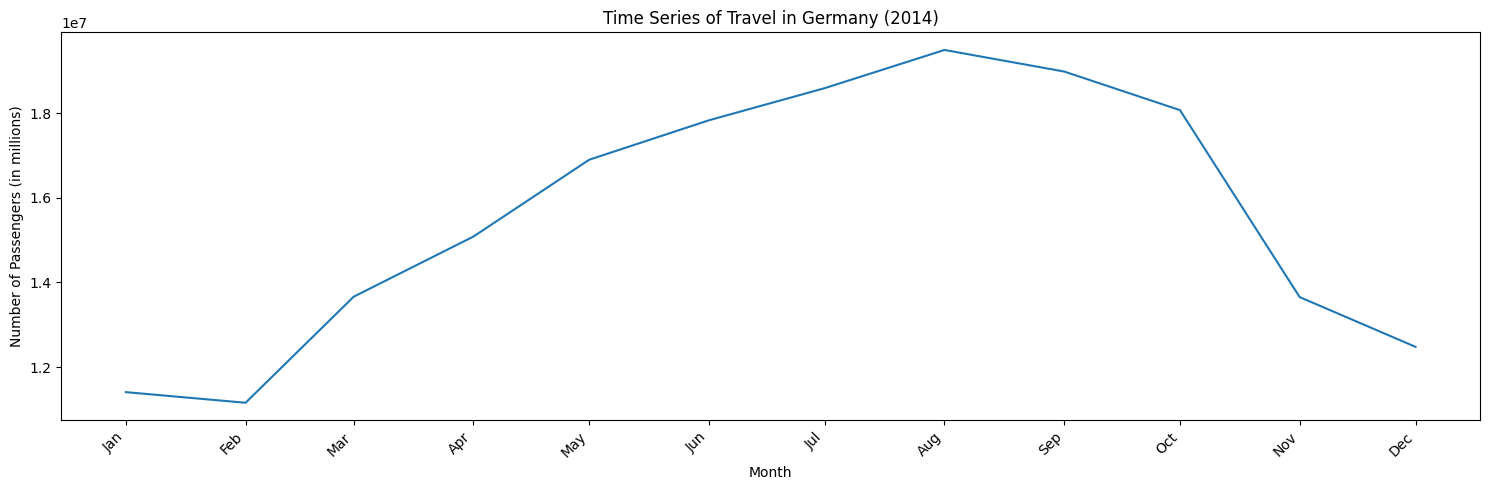

In [19]:
# Getting a better representation of the activity from the graph in which month are passengers most active

# Extract data for the year 2015
index = ob_cleaned['Total_Passengers'].loc['2014-01-01' : '2014-12-31'].index
data = ob_cleaned['Total_Passengers'].loc['2014-01-01' : '2014-12-31']

# Create subplots with specified figure size
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
ax.plot(index, data)

# Set title, labels, and format x-axis to show month names
ax.set_title('Time Series of Travel in Germany (2014)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Passengers (in millions)')

# Format x-axis to show month names
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Tick marks at each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Display month as abbreviation (e.g., Jan, Feb)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')  # Rotate labels for readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

[Text(0.5, 1.0, 'Time Series of Travel in Germany in 2015'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Number of passengers (in millions)')]

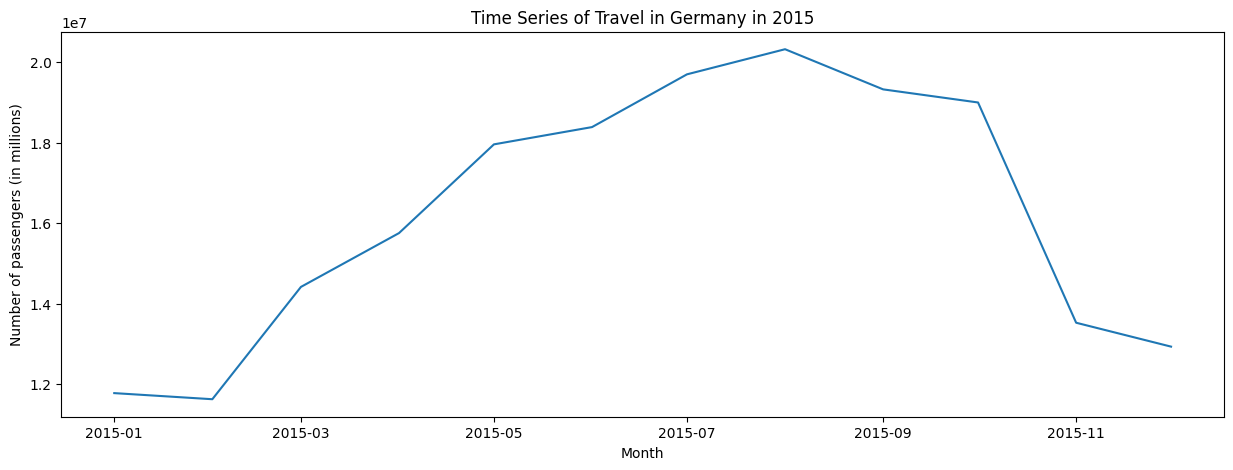

In [20]:
# Extract data for the year 2015
index = ob_cleaned['Total_Passengers'].loc['2015-01-01' : '2015-12-31'].index
data = ob_cleaned['Total_Passengers'].loc['2015-01-01' : '2015-12-31']

fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(index, data)
ax.set(title = 'Time Series of Travel in Germany in 2015', xlabel='Month', ylabel = 'Number of passengers (in millions)')
# ag_cleaned.loc['2022': '2024']['Total_Passengers'].plot(figsize=(15, 5), xlim=['2022', '2024'])

In [21]:
## EWMA - Exponential Weighted Moving Average. (alpha is a smoothing factor)
ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()
ob_cleaned['EMA_0.8'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.8, adjust = False).mean()
ob_cleaned['EMA_0.7'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.7, adjust = False).mean()
ob_cleaned['EMA_0.75'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.75, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\1704348808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()
C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\1704348808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.8'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.8, adjust = False).mean()
C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\1704348808.py:4: SettingWithCopyWarning: 
A va

<Axes: xlabel='TIME_PERIOD'>

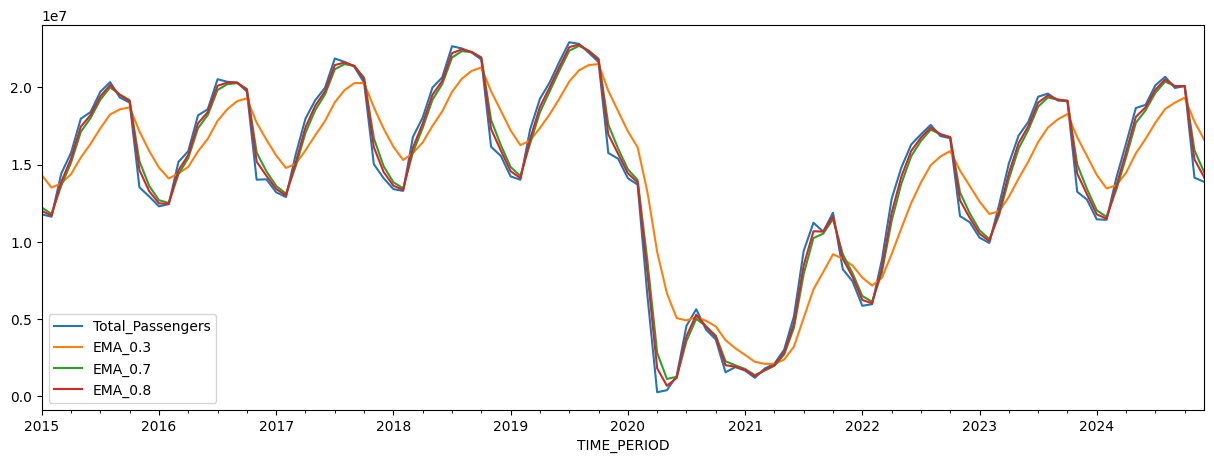

In [22]:
ob_cleaned.loc['2015' :' 2024'][['Total_Passengers', 'EMA_0.3','EMA_0.7', 'EMA_0.8']].plot(figsize=(15, 5))

<Axes: xlabel='TIME_PERIOD'>

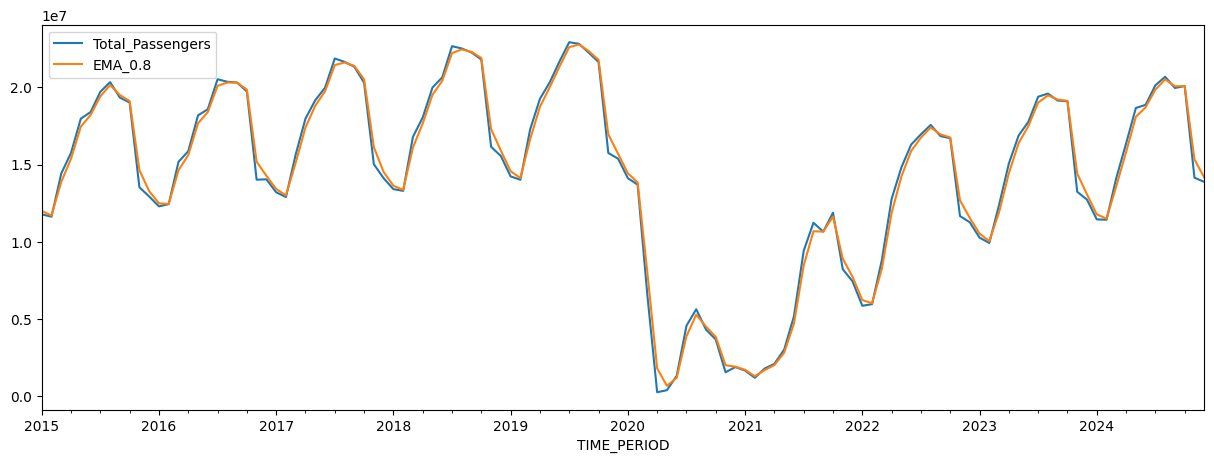

In [23]:
ob_cleaned.loc['2015' :' 2024'][['Total_Passengers', 'EMA_0.8']].plot(figsize=(15, 5))

<Axes: xlabel='TIME_PERIOD'>

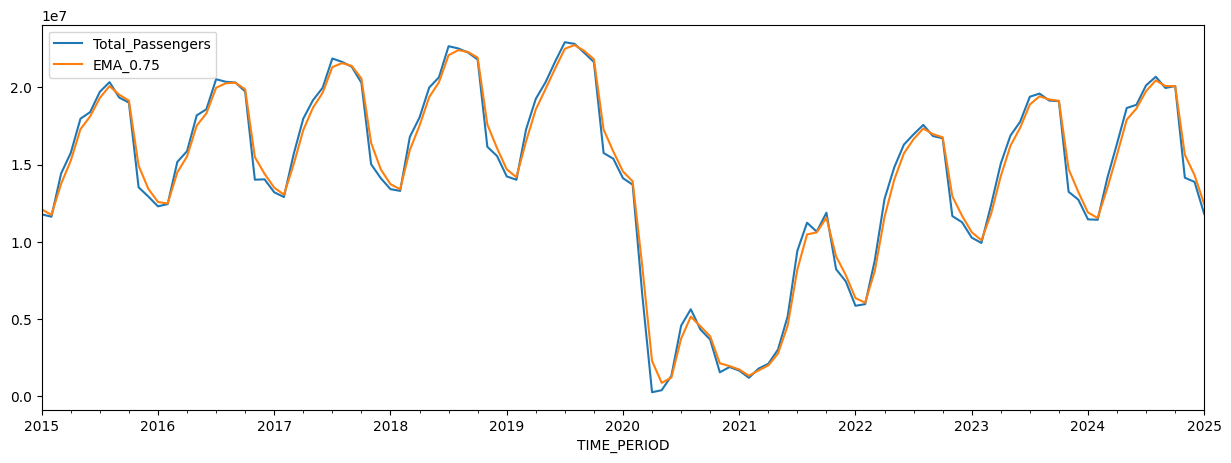

In [24]:
## EWMA - Exponential Weighted Moving Average. Testing which one gives a good representation of the data
ob_cleaned.loc['2015': '2025'][['Total_Passengers', 'EMA_0.75']].plot(figsize=(15, 5))

In [25]:
# More experimentation of different methods in Time Series (checking the data)

ob_cleaned['Rolling_window2'] = ob_cleaned['Total_Passengers'].rolling(window=2).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\2445358862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Rolling_window2'] = ob_cleaned['Total_Passengers'].rolling(window=2).mean()


<Axes: xlabel='TIME_PERIOD'>

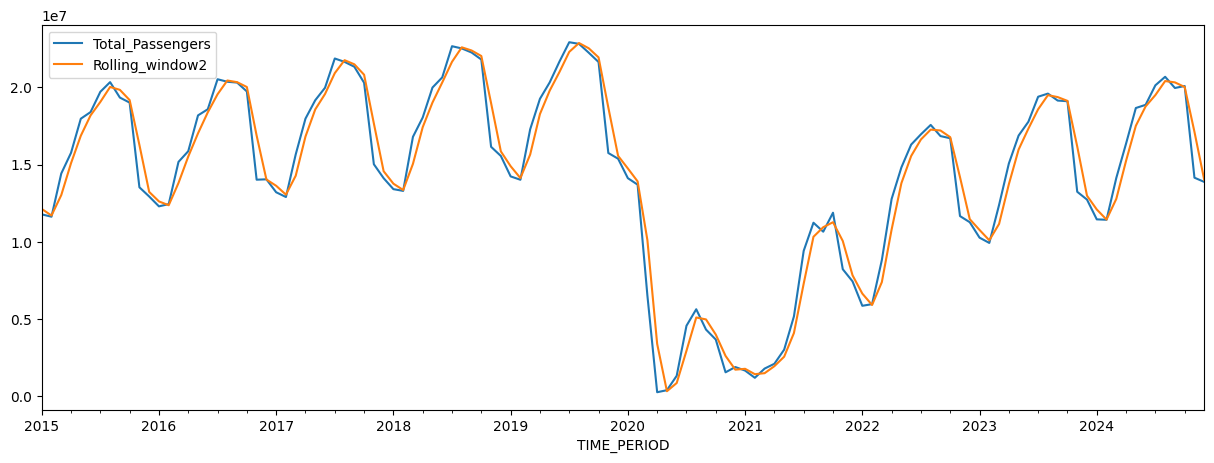

In [26]:
## EWMA - Exponential Weighted Moving Average
ob_cleaned.loc['2015': '2024'][['Total_Passengers', 'Rolling_window2']].plot(figsize=(15, 5))

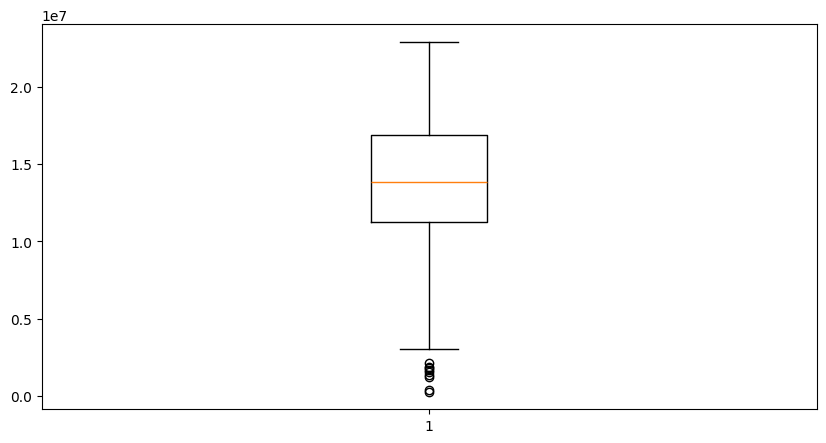

In [27]:
# Overall Boxplot to check for outliers everywhere

fig, ax = plt.subplots(figsize = (10,5 ))
ax.boxplot(x = 'Total_Passengers', data=ob_cleaned)
plt.show()

In [28]:
result = adfuller(ob_cleaned['Total_Passengers'])

C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\478834303.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(monthly_data, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',


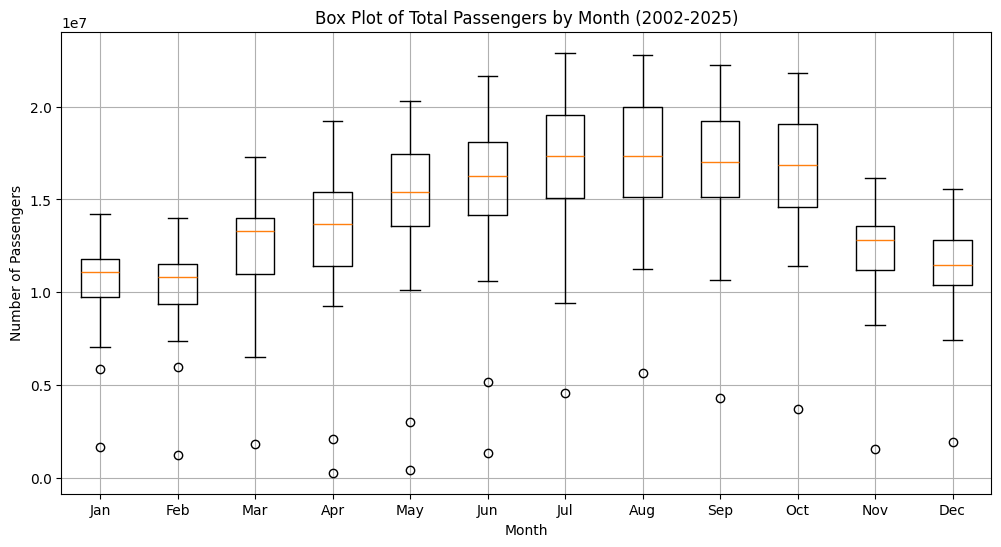

In [29]:
# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Group data by month (1 to 12) and create a list of passenger values for each month
monthly_data = [total_passengers[total_passengers.index.month == i].values for i in range(1, 13)]

# Create box plot
plt.figure(figsize=(12, 6))
plt.boxplot(monthly_data, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Customize the plot
plt.title('Box Plot of Total Passengers by Month (2002-2025)')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

z = (x - u) / s

In [30]:
# H0 = The graph is not stationary
# H1 = The graph is stationary

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print('We reject the null. The graph is stationary')
    else:
        print('We accept the null hypothesis, the graph is indeed not stationary')    

In [31]:
adfuller_test(ob_cleaned['Total_Passengers'])

ADF Test Statistic : -3.659785129833758
p-value : 0.004715716764461448
#Lags used : 13
We reject the null. The graph is stationary


In [32]:
ob_cleaned['Total_Passengers_First_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(1)

C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\3573525325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Total_Passengers_First_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(1)


<Axes: xlabel='TIME_PERIOD'>

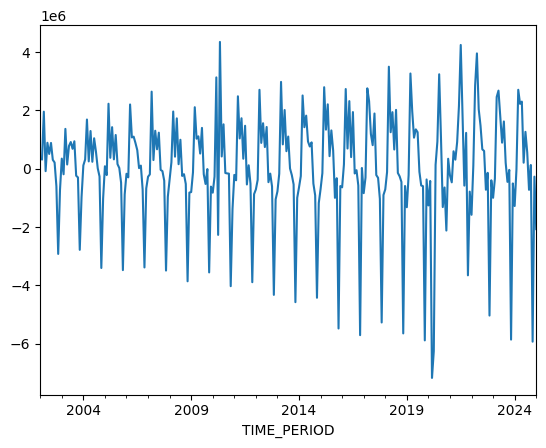

In [33]:
ob_cleaned['Total_Passengers_First_Difference'].plot()

In [34]:
ob_cleaned['Total_Passengers_Twelve_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(12)

C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\939315197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Total_Passengers_Twelve_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(12)


In [35]:
ob_cleaned[['Total_Passengers', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference']]

,Total_Passengers,Total_Passengers_First_Difference,Total_Passengers_Twelve_Difference
TIME_PERIOD,,,
2002-01-01,7044282,NaN,NaN
2002-02-01,7365242,320960.0,NaN
2002-03-01,9319495,1954253.0,NaN
2002-04-01,9235463,-84032.0,NaN
2002-05-01,10124069,888606.0,NaN
...,...,...,...
2024-09-01,19947957,-723872.0,813740.0
2024-10-01,20074786,126829.0,981930.0
2024-11-01,14147115,-5927671.0,910590.0


In [36]:
adfuller_test(ob_cleaned['Total_Passengers_First_Difference'].dropna())

ADF Test Statistic : -4.076495182962014
p-value : 0.0010588904145885337
#Lags used : 15
We reject the null. The graph is stationary


In [37]:
adfuller_test(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

ADF Test Statistic : -3.9757555991194717
p-value : 0.0015429203708297356
#Lags used : 13
We reject the null. The graph is stationary


<Axes: xlabel='TIME_PERIOD'>

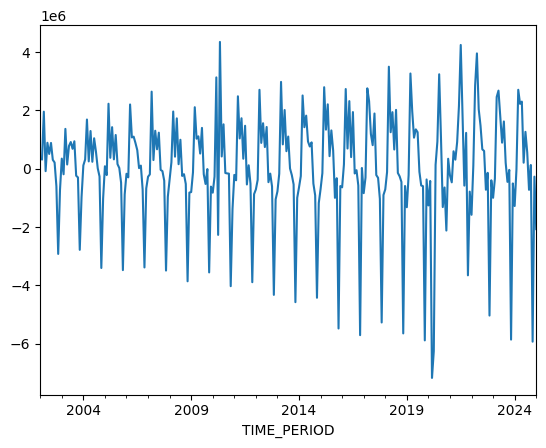

In [38]:
ob_cleaned['Total_Passengers_First_Difference'].plot()

<Axes: xlabel='TIME_PERIOD'>

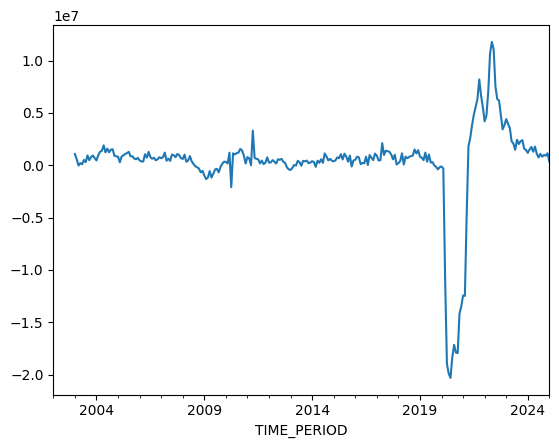

In [39]:
ob_cleaned['Total_Passengers_Twelve_Difference'].plot()

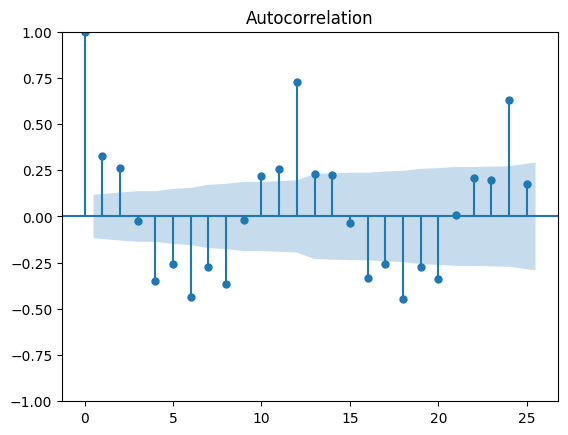

In [40]:
acf = plot_acf(ob_cleaned['Total_Passengers_First_Difference'].dropna())

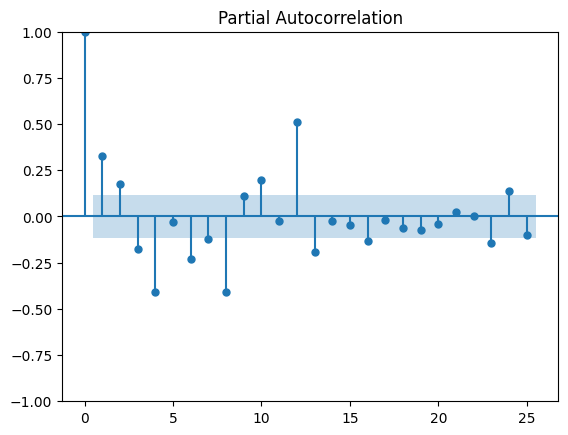

In [41]:
pacf = plot_pacf(ob_cleaned['Total_Passengers_First_Difference'].dropna())
#p = 25
#p = 13

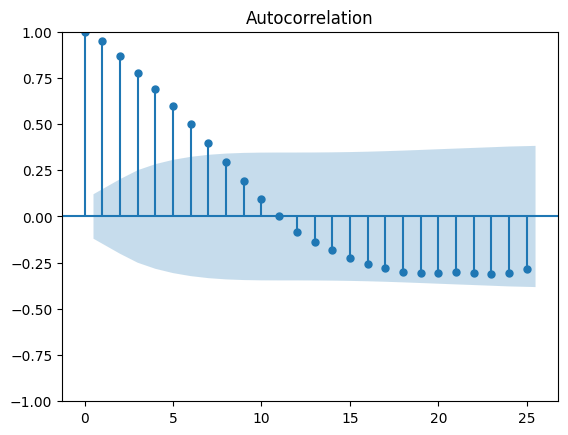

In [42]:
acf12 = plot_acf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

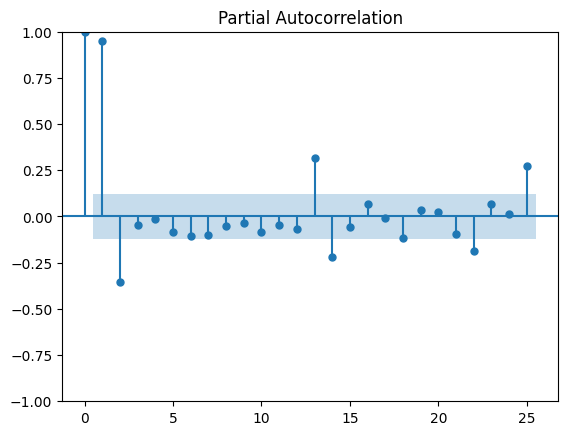

In [43]:
pacf12 = plot_pacf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

In [44]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2022, 12, 1)
test_dataset_end = datetime(2025, 1, 1)

In [45]:
train_data = ob_cleaned[:train_dataset_end]
test_data = ob_cleaned[train_dataset_end + timedelta(days = 1): test_dataset_end]

In [46]:
train_data.head()

,unit,tra_meas,tra_cov,geo,TIME_PERIOD,Total_Passengers,EMA_0.3,EMA_0.8,EMA_0.7,EMA_0.75,Rolling_window2,Total_Passengers_First_Difference,Total_Passengers_Twelve_Difference
TIME_PERIOD,,,,,,,,,,,,,
2002-01-01,Passenger,Passengers on board,Total transport,Germany,2002-01-01,7044282,7044282.000,7044282.00,7044282.000,7.044282e+06,NaN,NaN,NaN
2002-02-01,Passenger,Passengers on board,Total transport,Germany,2002-02-01,7365242,7140570.000,7301050.00,7268954.000,7.285002e+06,7204762.0,320960.0,NaN
2002-03-01,Passenger,Passengers on board,Total transport,Germany,2002-03-01,9319495,7794247.500,8915806.00,8704332.700,8.810872e+06,8342368.5,1954253.0,NaN
2002-04-01,Passenger,Passengers on board,Total transport,Germany,2002-04-01,9235463,8226612.150,9171531.60,9076123.910,9.129315e+06,9277479.0,-84032.0,NaN
2002-05-01,Passenger,Passengers on board,Total transport,Germany,2002-05-01,10124069,8795849.205,9933561.52,9809685.473,9.875381e+06,9679766.0,888606.0,NaN


In [47]:
model_ARIMA = ARIMA(train_data['Total_Passengers'], order = (12, 0, 12))

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [48]:
model_ARIMA_fit = model_ARIMA.fit()

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Total_Passengers   No. Observations:                  252
Model:               ARIMA(12, 0, 12)   Log Likelihood               -3843.726
Date:                Sat, 14 Jun 2025   AIC                           7739.453
Time:                        12:18:37   BIC                           7831.218
Sample:                    01-01-2002   HQIC                          7776.377
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.357e+07   2.31e-06   5.86e+12      0.000    1.36e+07    1.36e+07
ar.L1          1.1848      2.218      0.534      0.593      -3.161       5.531
ar.L2          0.6811      2.023      0.337      0.736      -3.284       4.646
ar.L3         -1.0750      2.014     -0.534      0.594      -5.023       2.873
ar.L4         -0.7806      1.775     -0.440      0.660      -4.260       2.698
ar.L5          1.1350      2.200      0.516      0.606      -3.177       5.447
ar.L6          0.6733      1.908      0.353      0.724      -3.067       4.414
ar.L7         -1.0256      1.963     -0.522      0.601      -4.874       2.823
ar.L8         -0.7792      1.688     -0.462      0.644      -4.087       2.529
ar.L9          1.1414      2.170      0.526      0.599      -3.111       5.394
ar.L10         0.6705      1.933      0.347      0.729      -3.118       4.459
ar.L11        -1.0722      1.972     -0.544      0.587      -4.938       2.794
ar.L12         0.2188      1.790      0.122      0.903      -3.290       3.728
ma.L1          0.1409      2.234      0.063      0.950      -4.237       4.519
ma.L2         -0.8428      0.986     -0.855      0.393      -2.775       1.089
ma.L3         -0.2037      1.633     -0.125      0.901      -3.404       2.997
ma.L4          0.9108      0.848      1.075      0.283      -0.750       2.572
ma.L5          0.2443      1.931      0.127      0.899      -3.539       4.028
ma.L6         -0.7031      1.103     -0.637      0.524      -2.865       1.459
ma.L7         -0.2240      1.335     -0.168      0.867      -2.841       2.393
ma.L8          0.7794      0.817      0.954      0.340      -0.822       2.381
ma.L9          0.1820      1.683      0.108      0.914      -3.116       3.480
ma.L10        -0.6920      0.913     -0.758      0.448      -2.481       1.097
ma.L11        -0.1128      1.359     -0.083      0.934      -2.777       2.552
ma.L12        -0.0029      0.596     -0.005      0.996      -1.172       1.166
sigma2      1.276e+12      1e-11   1.27e+23      0.000    1.28e+12    1.28e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             12701.34
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               7.70   Skew:                            -3.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.58e+40. Standard errors may be unstable.
"""

In [50]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2023-01-01 00:00:00
2025-01-01 00:00:00


In [51]:
pred = model_ARIMA_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data['Total_Passengers'] - pred

<Axes: ylabel='Density'>

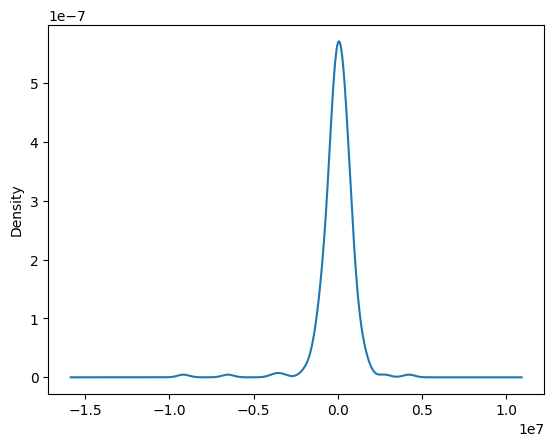

In [52]:
model_ARIMA_fit.resid.plot(kind = 'kde')

In [53]:
test_data['Predicted_ARIMA'] = pred

C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\284031954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA'] = pred


<Axes: xlabel='TIME_PERIOD'>

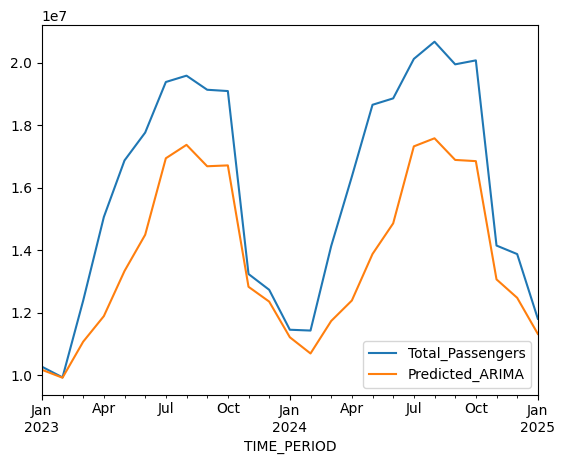

In [54]:
test_data[['Total_Passengers', 'Predicted_ARIMA']].plot()

In [55]:
ob_cleaned.columns

Index(['unit', 'tra_meas', 'tra_cov', 'geo', 'TIME_PERIOD', 'Total_Passengers',
       'EMA_0.3', 'EMA_0.8', 'EMA_0.7', 'EMA_0.75', 'Rolling_window2',
       'Total_Passengers_First_Difference',
       'Total_Passengers_Twelve_Difference'],
      dtype='object')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7276.875, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7848.460, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7320.970, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7672.275, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8382.471, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7291.025, Time=0.53 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=7274.885, Time=0.84 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7347.029, Time=0.28 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=7274.101, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=7357.799, Time=0.16 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=7272.269, Time=1.19 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


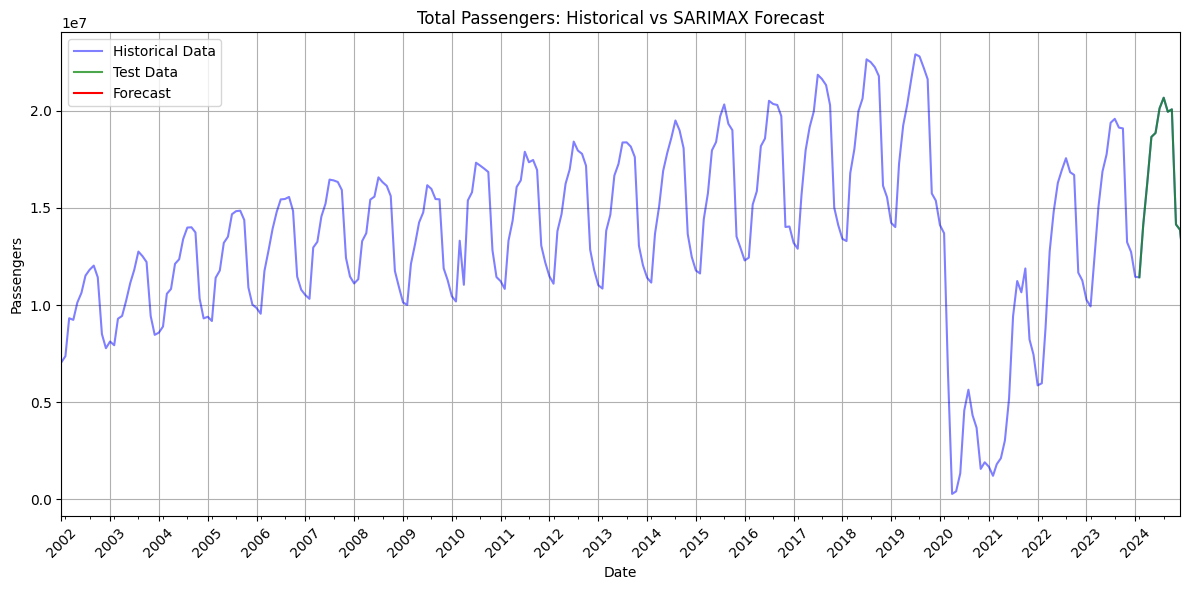

Train end date: 2024-01-01 00:00:00
Test data values: [11426285 14130802 16353547 18653005 18858441 20121631 20671829 19947957
 20074786 14147115 13874296 11803557]
Forecast values for test period: 2022-07-01    1.695126e+07
2022-08-01    1.755924e+07
2022-09-01    1.683824e+07
2022-10-01    1.669673e+07
2022-11-01    1.166398e+07
2022-12-01    1.126685e+07
2023-01-01    1.026995e+07
2023-02-01    9.926918e+06
2023-03-01    1.238479e+07
2023-04-01    1.506100e+07
2023-05-01    1.687152e+07
2023-06-01    1.776352e+07
Freq: MS, Name: predicted_mean, dtype: float64
MAE on test set: 5452301.416660978


In [106]:
# Extracting Total_Passengers as the target variable
total_passengers = ob_cleaned['Total_Passengers']

# Split into train and test (last 12 months for testing)
train_end = total_passengers.index[-13]
train_data = total_passengers[total_passengers.index <= train_end]
test_data = total_passengers[total_passengers.index > train_end]

# Exogenous variables (features from column 6 onwards)
train_exog = ob_cleaned.iloc[:-31, 6:].dropna()  # Drop rows with NaN
test_exog = ob_cleaned.iloc[-31:, 6:].dropna()   # Drop rows with NaN
train_data = train_data[train_data.index.isin(train_exog.index)]
test_data = test_data[test_data.index.isin(test_exog.index)]

# Define SARIMAX model parameters using auto_arima
model_auto = auto_arima(train_data, exogenous=train_exog, seasonal=True, m=12, trace=True)
p, d, q = model_auto.order
P, D, Q, s = model_auto.seasonal_order
print(f"Optimal ARIMA order: {p, d, q}")
print(f"Optimal seasonal order: {P, D, Q, s}")

# Fit SARIMAX model with optimal parameters
model = SARIMAX(
    train_data,
    exog=train_exog,
    order=(p, d, q),
    seasonal_order=(P, D, Q, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
fit_model = model.fit()

# Forecast only the 12-month test period
forecast = fit_model.forecast(len(test_data), exog=test_exog.iloc[:len(test_data)])

# Create date range for the forecast
future_dates = pd.date_range(start=train_end, periods=len(test_data), freq='MS')

# Create forecast DataFrame
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Plot the original data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data, label='Test Data', color='green', alpha=0.7)
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits and format
plt.xlim(total_passengers.index[0], future_dates[-1])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
plt.title('Total Passengers: Historical vs SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate and print MAE
mae = mean_absolute_error(test_data, forecast)
print("Train end date:", train_end)
print("Test data values:", test_data.values)
print("Forecast values for test period:", forecast)
print("MAE on test set:", mae)

Length of train_data: 246
Length of test_data: 12
Length of train_exog: 246
Length of test_exog: 31
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=7640.041, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8248.974, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7687.070, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8061.792, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8805.744, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=7656.794, Time=0.48 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=7638.050, Time=0.91 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=7717.226, Time=0.21 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=7637.646, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=7728.270, Time=0.16 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=7635.300, Time=1.31 

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast array: 2022-07-01    1.694948e+07
2022-08-01    1.755843e+07
2022-09-01    1.683848e+07
2022-10-01    1.669864e+07
2022-11-01    1.166551e+07
2022-12-01    1.126734e+07
2023-01-01    1.026858e+07
2023-02-01    9.927487e+06
2023-03-01    1.238406e+07
2023-04-01    1.506085e+07
2023-05-01    1.687215e+07
2023-06-01    1.776374e+07
Freq: MS, Name: predicted_mean, dtype: float64
Forecast DataFrame:
             Total_Passengers
2022-07-01      1.694948e+07
2022-08-01      1.755843e+07
2022-09-01      1.683848e+07
2022-10-01      1.669864e+07
2022-11-01      1.166551e+07
2022-12-01      1.126734e+07
2023-01-01      1.026858e+07
2023-02-01      9.927487e+06
2023-03-01      1.238406e+07
2023-04-01      1.506085e+07
2023-05-01      1.687215e+07
2023-06-01      1.776374e+07


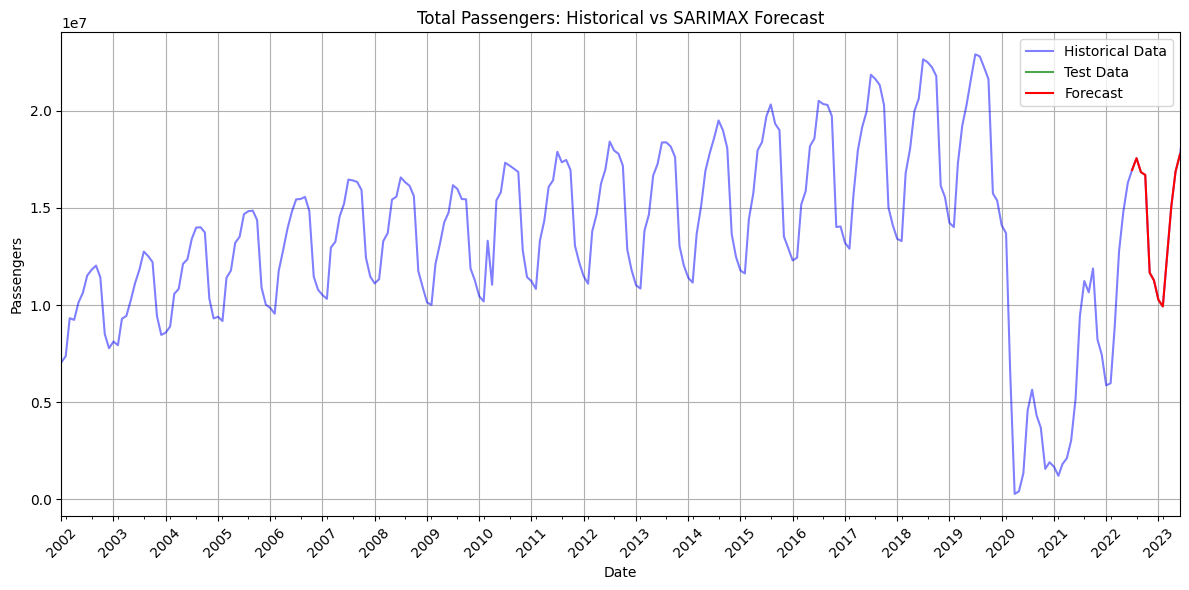

Train end date: 2024-01-01 00:00:00
Test data values: [11426285 14130802 16353547 18653005 18858441 20121631 20671829 19947957
 20074786 14147115 13874296 11803557]
Forecast values for test period: [16949476.05456216 17558427.1694824  16838480.66355486 16698641.32117997
 11665507.86656055 11267340.81050078 10268578.61490079  9927486.90947898
 12384062.75500305 15060848.88578272 16872154.65291171 17763739.35494271]
MAE on test set: 5451962.95863437


In [107]:
# Extract Total_Passengers as the target variable
total_passengers = ob_cleaned['Total_Passengers']

# Split into train and test (last 12 months for testing)
train_end = total_passengers.index[-13]
train_data = total_passengers[total_passengers.index <= train_end]
test_data = total_passengers[total_passengers.index > train_end]

# Exogenous variables (features from column 6 onwards)
train_exog = ob_cleaned.iloc[:-31, 6:].fillna(ob_cleaned.iloc[:-31, 6:].mean())
test_exog = ob_cleaned.iloc[-31:, 6:].fillna(ob_cleaned.iloc[-31:, 6:].mean())

# Align train_data and test_data with exogenous data indices
train_data = train_data[train_data.index.isin(train_exog.index)]
test_data = test_data[test_data.index.isin(test_exog.index)]

# Debug: Print lengths to check alignment
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))
print("Length of train_exog:", len(train_exog))
print("Length of test_exog:", len(test_exog))

# Define SARIMAX model parameters using auto_arima
model_auto = auto_arima(train_data, exogenous=train_exog, seasonal=True, m=12, trace=True)
p, d, q = model_auto.order
P, D, Q, s = model_auto.seasonal_order
print(f"Optimal ARIMA order: {p, d, q}")
print(f"Optimal seasonal order: {P, D, Q, s}")

# Fit SARIMAX model with optimal parameters
model = SARIMAX(
    train_data,
    exog=train_exog,
    order=(p, d, q),
    seasonal_order=(P, D, Q, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
fit_model = model.fit()

# Forecast only the 12-month test period
forecast = fit_model.forecast(len(test_data), exog=test_exog.iloc[:len(test_data)])

# Use the forecast Series' index directly
forecast_df = pd.DataFrame({'Total_Passengers': forecast.values}, index=forecast.index)

# Debug: Print forecast and DataFrame to verify
print("Forecast array:", forecast)
print("Forecast DataFrame:\n", forecast_df)

# Plot the original data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data, label='Test Data', color='green', alpha=0.7)
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits and format
plt.xlim(total_passengers.index[0], forecast_df.index[-1])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
plt.title('Total Passengers: Historical vs SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate and print MAE
mae = mean_absolute_error(test_data, forecast)
print("Train end date:", train_end)
print("Test data values:", test_data.values)
print("Forecast values for test period:", forecast.values)
print("MAE on test set:", mae)

Length of train_data: 234
Length of test_data: 12
Length of train_exog: 234
Length of test_exog: 31
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7848.460, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7320.970, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7672.275, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8382.471, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7412.666, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7322.201, Time=0.76 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7321.039, Time=0.42 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7337.021, Time=0.21 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=7843.882, Time=0.15 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=7295.378, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=7375.090, Time=0.10 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=7296.968, Time=

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast array: 2022-07-01    1.695126e+07
2022-08-01    1.755924e+07
2022-09-01    1.683824e+07
2022-10-01    1.669673e+07
2022-11-01    1.166398e+07
2022-12-01    1.126685e+07
2023-01-01    1.026995e+07
2023-02-01    9.926918e+06
2023-03-01    1.238479e+07
2023-04-01    1.506100e+07
2023-05-01    1.687151e+07
2023-06-01    1.776352e+07
Freq: MS, Name: predicted_mean, dtype: float64
Forecast DataFrame:
             Total_Passengers
2022-07-01      1.695126e+07
2022-08-01      1.755924e+07
2022-09-01      1.683824e+07
2022-10-01      1.669673e+07
2022-11-01      1.166398e+07
2022-12-01      1.126685e+07
2023-01-01      1.026995e+07
2023-02-01      9.926918e+06
2023-03-01      1.238479e+07
2023-04-01      1.506100e+07
2023-05-01      1.687151e+07
2023-06-01      1.776352e+07


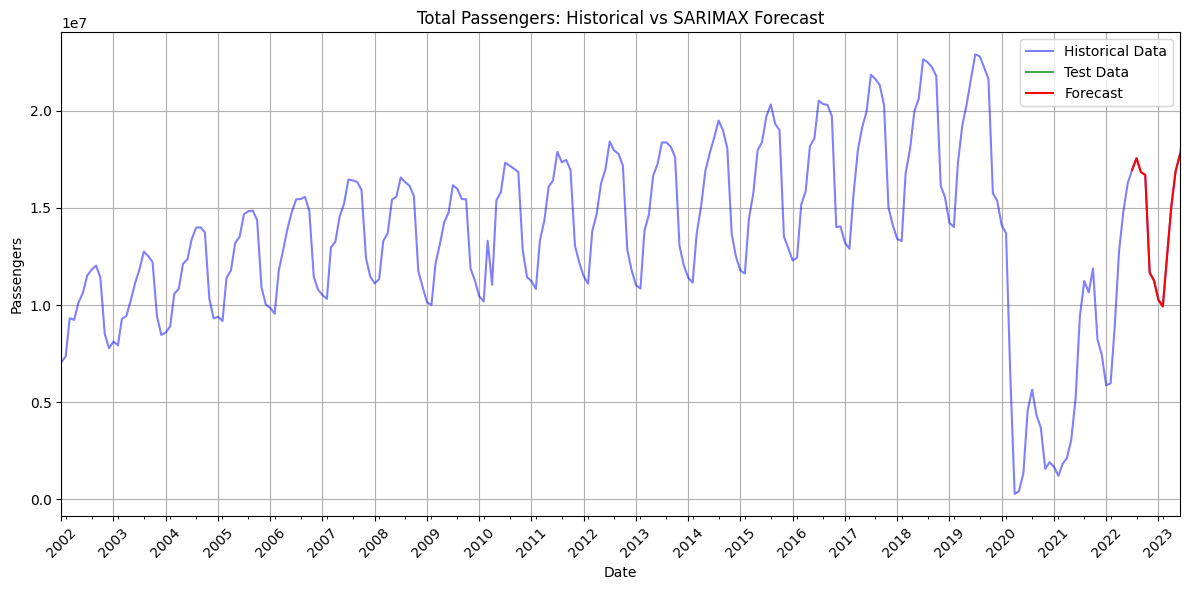

Train end date: 2024-01-01 00:00:00
Test data values: [11426285 14130802 16353547 18653005 18858441 20121631 20671829 19947957
 20074786 14147115 13874296 11803557]
Forecast values for test period: [16951262.00000253 17559242.00000431 16838243.00000535 16696727.00000787
 11663982.00000762 11266852.0000057  10269954.00000338  9926918.0000034
 12384785.99999848 15061003.99999294 16871514.99999182 17763522.99999104]
MAE on test set: 5452301.416663461


In [108]:
# Assuming ob_cleaned is your DataFrame with 'Total_Passengers' and 'TIME_PERIOD' inde
# Extract Total_Passengers as the target variable
total_passengers = ob_cleaned['Total_Passengers']

# Split into train and test (last 12 months for testing)
train_end = total_passengers.index[-13]
train_data = total_passengers[total_passengers.index <= train_end]
test_data = total_passengers[total_passengers.index > train_end]

# Exogenous variables (features from column 6 onwards)
train_exog = ob_cleaned.iloc[:-31, 6:].dropna()  # Drop rows with NaN
test_exog = ob_cleaned.iloc[-31:, 6:].dropna()   # Drop rows with NaN
train_data = train_data[train_data.index.isin(train_exog.index)]
test_data = test_data[test_data.index.isin(test_exog.index)]

# Debug: Print lengths to check alignment
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))
print("Length of train_exog:", len(train_exog))
print("Length of test_exog:", len(test_exog))

# Define SARIMAX model parameters using auto_arima with simplified orders
model_auto = auto_arima(train_data, exogenous=train_exog, seasonal=True, m=12, 
                       start_p=0, start_q=0, max_p=2, max_q=2, 
                       start_P=0, start_Q=0, max_P=2, max_Q=2, 
                       d=0, D=0, trace=True)  # Keep d=0, D=0 for stationary data
p, d, q = model_auto.order
P, D, Q, s = model_auto.seasonal_order
print(f"Optimal ARIMA order: {p, d, q}")
print(f"Optimal seasonal order: {P, D, Q, s}")

# Fit SARIMAX model with optimal parameters
model = SARIMAX(
    train_data,
    exog=train_exog,
    order=(p, d, q),
    seasonal_order=(P, D, Q, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
fit_model = model.fit()

# Forecast only the 12-month test period
forecast = fit_model.forecast(len(test_data), exog=test_exog.iloc[:len(test_data)])

# Use the forecast Series' index directly
forecast_df = pd.DataFrame({'Total_Passengers': forecast.values}, index=forecast.index)

# Debug: Print forecast and DataFrame to verify
print("Forecast array:", forecast)
print("Forecast DataFrame:\n", forecast_df)

# Plot the original data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data, label='Test Data', color='green', alpha=0.7)
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits and format
plt.xlim(total_passengers.index[0], forecast_df.index[-1])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
plt.title('Total Passengers: Historical vs SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate and print MAE
mae = mean_absolute_error(test_data, forecast)
print("Train end date:", train_end)
print("Test data values:", test_data.values)
print("Forecast values for test period:", forecast.values)
print("MAE on test set:", mae)

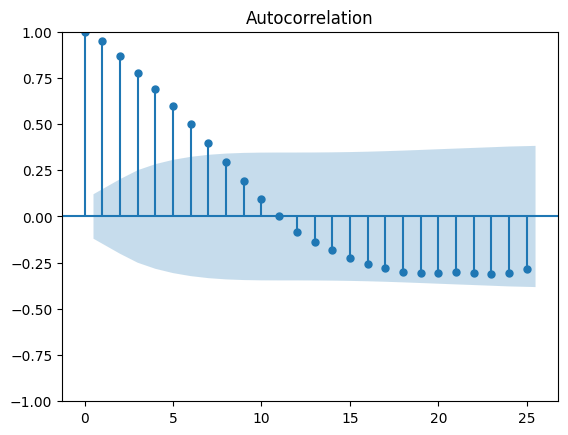

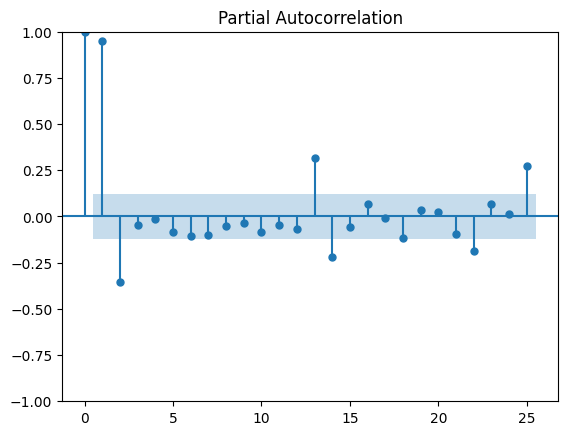

In [59]:
acf12 = plot_acf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())
pacf12 = plot_pacf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

In [60]:
ob_cleaned.drop(labels=['Rolling_window2', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference'], axis =1 )

,unit,tra_meas,tra_cov,geo,TIME_PERIOD,Total_Passengers,EMA_0.3,EMA_0.8,EMA_0.7,EMA_0.75
TIME_PERIOD,,,,,,,,,,
2002-01-01,Passenger,Passengers on board,Total transport,Germany,2002-01-01,7044282,7.044282e+06,7.044282e+06,7.044282e+06,7.044282e+06
2002-02-01,Passenger,Passengers on board,Total transport,Germany,2002-02-01,7365242,7.140570e+06,7.301050e+06,7.268954e+06,7.285002e+06
2002-03-01,Passenger,Passengers on board,Total transport,Germany,2002-03-01,9319495,7.794248e+06,8.915806e+06,8.704333e+06,8.810872e+06
2002-04-01,Passenger,Passengers on board,Total transport,Germany,2002-04-01,9235463,8.226612e+06,9.171532e+06,9.076124e+06,9.129315e+06
2002-05-01,Passenger,Passengers on board,Total transport,Germany,2002-05-01,10124069,8.795849e+06,9.933562e+06,9.809685e+06,9.875381e+06
...,...,...,...,...,...,...,...,...,...,...
2024-09-01,Passenger,Passengers on board,Total transport,Germany,2024-09-01,19947957,1.899863e+07,2.005938e+07,2.007207e+07,2.007105e+07
2024-10-01,Passenger,Passengers on board,Total transport,Germany,2024-10-01,20074786,1.932148e+07,2.007170e+07,2.007397e+07,2.007385e+07
2024-11-01,Passenger,Passengers on board,Total transport,Germany,2024-11-01,14147115,1.776917e+07,1.533203e+07,1.592517e+07,1.562880e+07


In [61]:
# # Assuming ob_cleaned is your DataFrame
# # Split the data: last 31 periods for testing, rest for training
# training_y = ob_cleaned.iloc[:-31, 5]  # Target variable (Total_Passengers) for training
# test_y = ob_cleaned.iloc[-31:, 5]   # Target variable (Total_Passengers) for testing

# # Exogenous variables (features from column 6 onwards)
# training_X = ob_cleaned.iloc[:-31, 6:]  # Exogenous variables for training
# test_X = ob_cleaned.iloc[-31:, 6:]   # Exogenous variables for testing

In [62]:
# training_X.drop(labels=['Rolling_window2', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference'], axis =1, inplace=True)
# test_X.drop(labels=['Rolling_window2', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference'], axis =1, inplace=True)


In [63]:
# model = auto_arima(y = training_y,
#                    X = training_X,
#                    seasonal=True,
#                    m = 12)

In [64]:
# predictions = pd.Series(model.predict(n_periods=31,
#               X = test_X))

In [65]:
# training_y.plot(figsize=(16, 8), legend=True)
# test_y.plot(legend=True)
# predictions.plot()

In [66]:
# model_SARIMA = SARIMAX(train_data['Total_Passengers'], order = (18,1,7), seasonal_order=(0,1,0,12))

In [67]:
# pred_start_date = test_data.index[0]
# pred_end_date = test_data.index[-1]
# print(pred_start_date)
# print(pred_end_date)

In [68]:
# model_SARIMA_fit = model_SARIMA.fit()

In [69]:
# model_SARIMA_fit.summary()

In [70]:
# pred_SARIMA = model_SARIMA_fit.predict(start = datetime(2024, 6, 6), end = datetime(2025, 1, 1))

In [71]:
# residuals = test_X['Total_Passengers'] - predictions

In [72]:
# model_SARIMA_fit.resid.plot(kind = 'kde')

In [73]:
# test_data['Predicted_SARIMA'] = pred_SARIMA

## Note for Louis: This doesn't look good. This needs to improve

In [74]:
# test_data[['Total_Passengers', 'Predicted_SARIMA', 'Predicted_ARIMA']].plot()

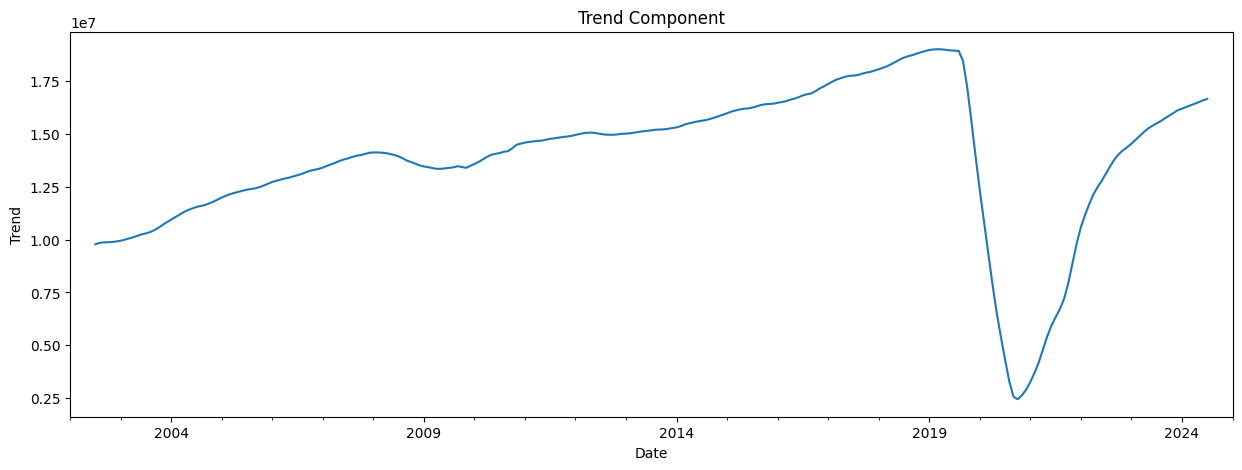

In [75]:
# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition
decomposition = seasonal_decompose(total_passengers, model='additive', period=12)

# Create two subplots side by side
fig, ax = plt.subplots(figsize=(15, 5))  # 1 row, 2 columns

# # Plot seasonal component on the first subplot
# decomposition.observed.plot(ax=ax1, title = 'Observed Passengers')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Seasonal')

# # Plot seasonal component on the first subplot
# decomposition.seasonal.plot(ax=ax1, title='Seasonal Component')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Seasonal')

# Plot trend component on the second subplot
decomposition.trend.plot(ax=ax, title='Trend Component')
ax.set_xlabel('Date')
ax.set_ylabel('Trend')

# Show the plots
plt.show()

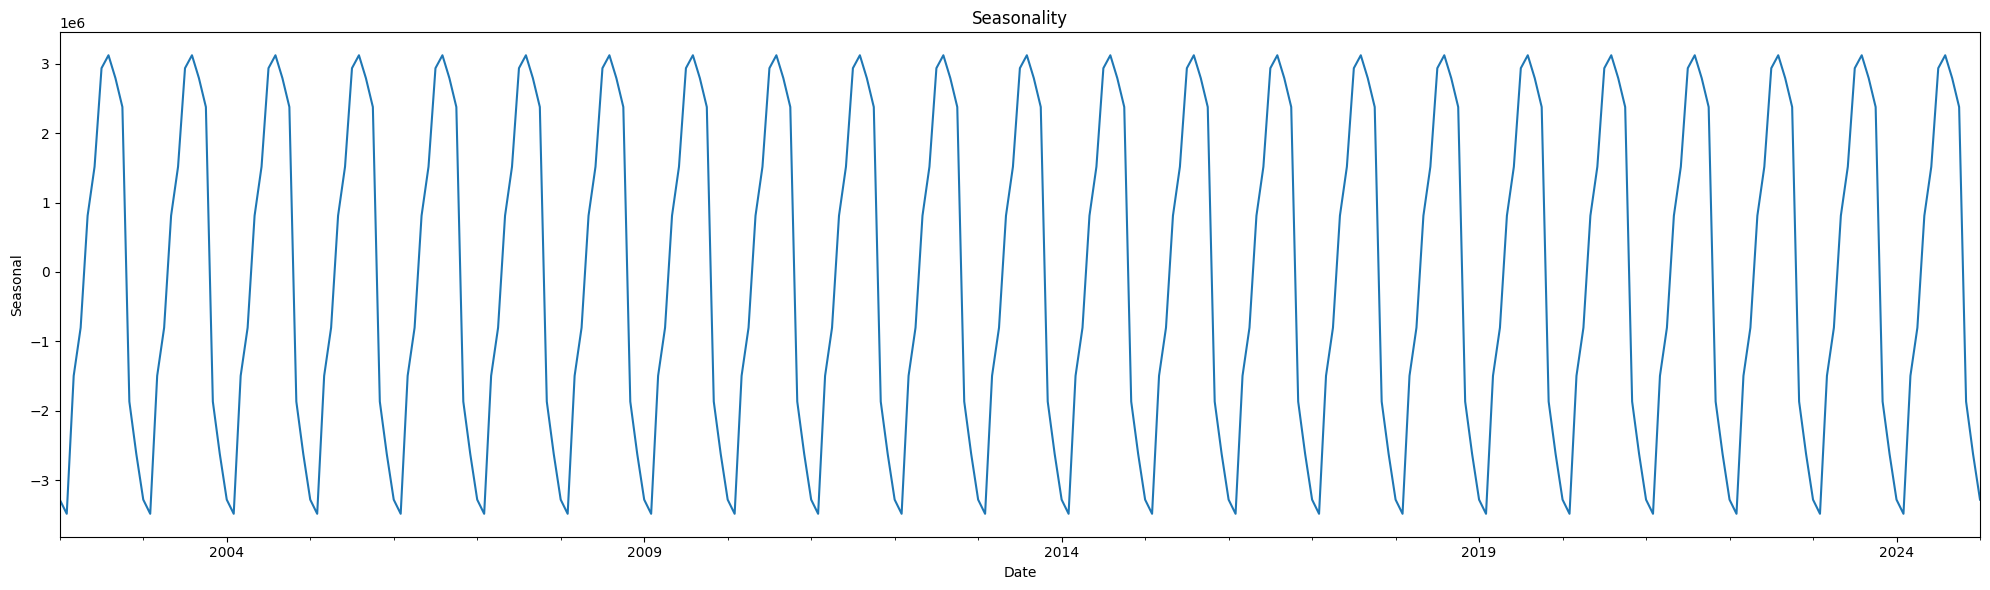

In [76]:


# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition
decomposition = seasonal_decompose(total_passengers, model='additive', period=12)

# Create two subplots side by side
fig, ax = plt.subplots(figsize=(20, 6))  # 1 row, 2 columns

# # Plot seasonal component on the first subplot
# decomposition.observed.plot(ax=ax1, title = 'Observed Passengers')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Seasonal')

# Plot seasonal component on the first subplot
decomposition.seasonal.plot(ax=ax, title='Seasonality')
ax.set_xlabel('Date')
ax.set_ylabel('Seasonal')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

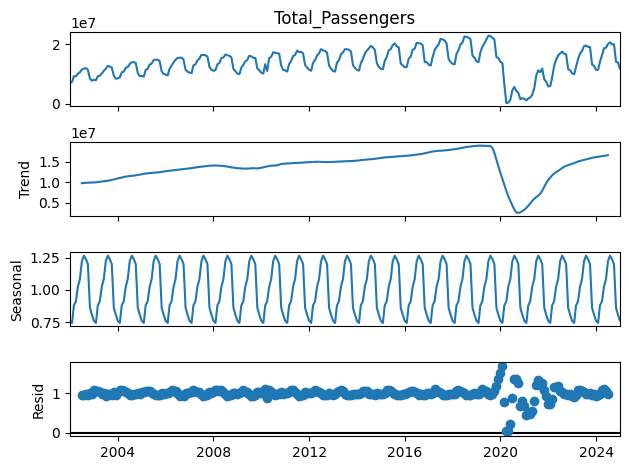

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition (assuming monthly data with 12 periods per year)
decomposition = seasonal_decompose(total_passengers, model='multiplicative', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

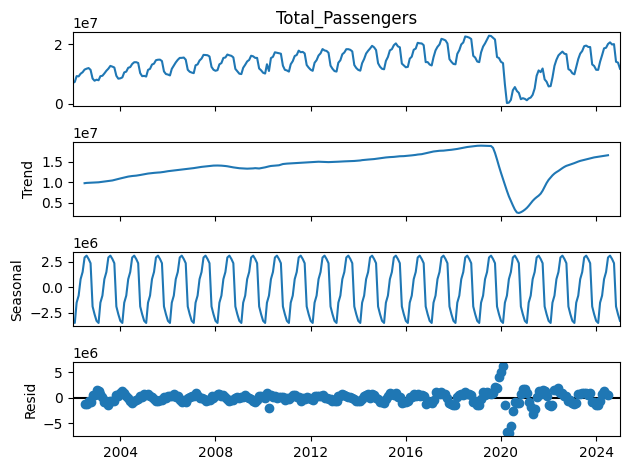

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition (assuming monthly data with 12 periods per year)
decomposition = seasonal_decompose(total_passengers, model='subtraction', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


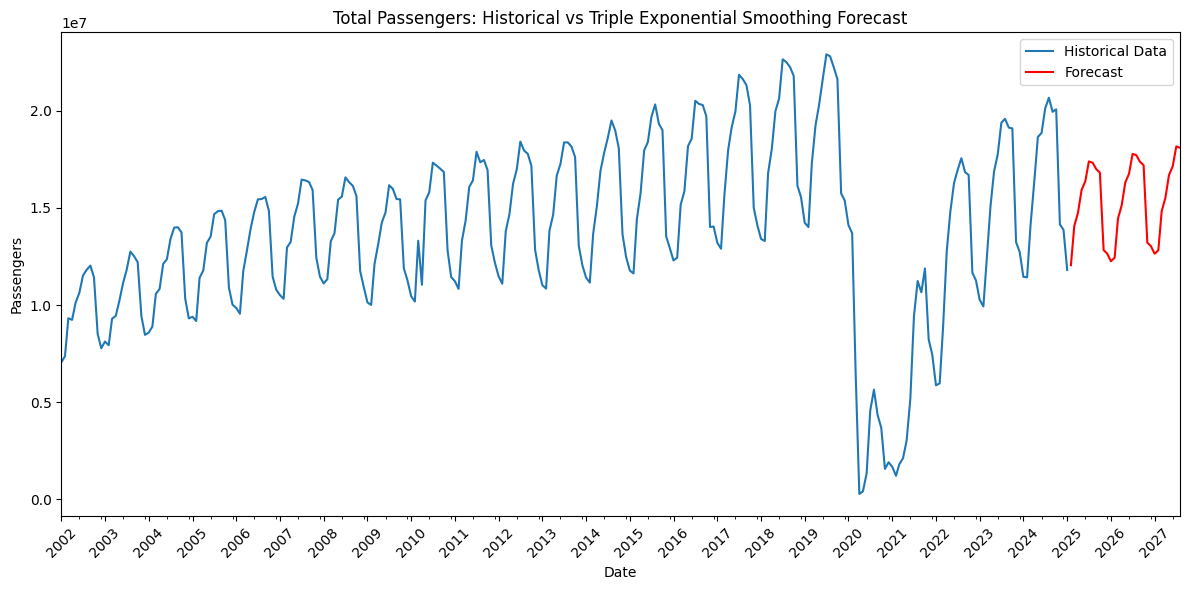

Last historical date: 2025-01-01 00:00:00
Forecast values: 2025-02-01    1.204807e+07
2025-03-01    1.406498e+07
2025-04-01    1.474932e+07
2025-05-01    1.592312e+07
2025-06-01    1.637014e+07
2025-07-01    1.739385e+07
2025-08-01    1.733017e+07
2025-09-01    1.698962e+07
2025-10-01    1.681604e+07
2025-11-01    1.282933e+07
2025-12-01    1.264572e+07
2026-01-01    1.225541e+07
2026-02-01    1.243210e+07
2026-03-01    1.444900e+07
2026-04-01    1.513335e+07
2026-05-01    1.630714e+07
2026-06-01    1.675417e+07
2026-07-01    1.777788e+07
2026-08-01    1.771419e+07
2026-09-01    1.737365e+07
2026-10-01    1.720006e+07
2026-11-01    1.321336e+07
2026-12-01    1.302974e+07
2027-01-01    1.263943e+07
2027-02-01    1.281612e+07
2027-03-01    1.483303e+07
2027-04-01    1.551738e+07
2027-05-01    1.669117e+07
2027-06-01    1.713819e+07
2027-07-01    1.816190e+07
2027-08-01    1.809822e+07
Freq: MS, dtype: float64
Forecast DataFrame:
             Total_Passengers
2025-02-01      1.204807e+07


In [79]:
# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Define the seasonal period (e.g., 12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing (Holt-Winters)
model = ExponentialSmoothing(
    total_passengers,
    seasonal_periods=seasonal_periods,
    trend='add',
    seasonal='add',
    initialization_method='heuristic'
)

# Fit the model
fit_model = model.fit()

# Forecast the next 31 periods
forecast = fit_model.forecast(31)

# Create a date range for the forecast starting from '2025-02-01'
future_dates = pd.date_range(start='2025-02-01', periods=31, freq='MS')  # MS for start of month

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits to include the full range
plt.xlim(total_passengers.index[0], future_dates[-1])

# Format x-axis to show dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))  # Minor ticks every 6 months

plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Print to verify
print("Last historical date:", total_passengers.index[-1])
print("Forecast values:", forecast)
print("Forecast DataFrame:\n", forecast_df)

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


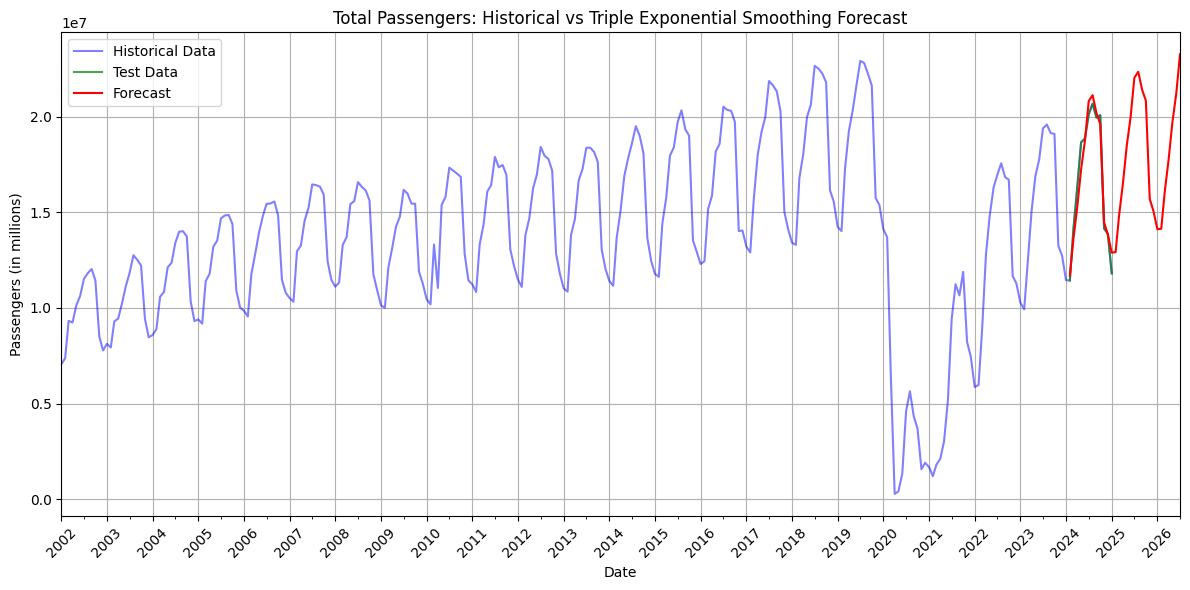

Train end date: 2024-01-01 00:00:00
Test data values: [11426285 14130802 16353547 18653005 18858441 20121631 20671829 19947957
 20074786 14147115 13874296 11803557]
Forecast values: 2024-02-01    1.169129e+07
2024-03-01    1.361973e+07
2024-04-01    1.530979e+07
2024-05-01    1.724210e+07
2024-06-01    1.875217e+07
2024-07-01    2.080867e+07
2024-08-01    2.112014e+07
2024-09-01    2.017863e+07
2024-10-01    1.960952e+07
2024-11-01    1.447050e+07
2024-12-01    1.383085e+07
2025-01-01    1.288708e+07
2025-02-01    1.291434e+07
2025-03-01    1.484279e+07
2025-04-01    1.653285e+07
2025-05-01    1.846516e+07
2025-06-01    1.997523e+07
2025-07-01    2.203172e+07
2025-08-01    2.234320e+07
2025-09-01    2.140168e+07
2025-10-01    2.083257e+07
2025-11-01    1.569355e+07
2025-12-01    1.505390e+07
2026-01-01    1.411013e+07
2026-02-01    1.413740e+07
2026-03-01    1.606584e+07
2026-04-01    1.775590e+07
2026-05-01    1.968821e+07
2026-06-01    2.119828e+07
2026-07-01    2.325478e+07
2026-08-

In [127]:
# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Split into train and test (12 months for testing. The rest before that is training)
train_end = total_passengers.index[-13]  # 12 months before the end
train_data = total_passengers[total_passengers.index <= train_end]
test_data = total_passengers[total_passengers.index > train_end]

# Defining the seasonal period (12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing (Holt-Winters) with tuned parameters
model = ExponentialSmoothing(
    train_data,
    seasonal_periods=seasonal_periods,
    trend='additive',  # Try multiplicative trend
    seasonal='additive',  # Try multiplicative seasonality
    initialization_method='heuristic'
)

# Fit the model with custom smoothing parameters
# fit_model = model.fit(smoothing_level=0.5, smoothing_trend=0.15, smoothing_seasonal=0.15)
fit_model = model.fit(smoothing_level=0.5, smoothing_trend=0.15, smoothing_seasonal=0.17)
# fit_model = model.fit(smoothing_level=0.5, smoothing_trend=0.15, smoothing_seasonal=0.2)


# Forecast the next 31 periods (including test period for validation)
forecast = fit_model.forecast(31)

# Create a date range for the forecast starting from the day after train_end
future_dates = pd.date_range(start=train_end, periods=31, freq='MS')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Plot the original data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data, label='Test Data', color='green', alpha=0.7)
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits to include the full range
plt.xlim(total_passengers.index[0], future_dates[-1])

# Format x-axis to show dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))

plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers (in millions)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Print to verify
print("Train end date:", train_end)
print("Test data values:", test_data.values)
print("Forecast values:", forecast)
print("Forecast DataFrame:\n", forecast_df)

In [128]:
mae = mean_absolute_error(test_data, forecast[:len(test_data)])
rmse = root_mean_squared_error(test_data, forecast[:len(test_data)])
mape = mean_absolute_percentage_error(test_data, forecast[:len(test_data)]) * 100

print("MAE on test set:", mae)
print("RMSE on test set:", rmse)
print("MAPE on test set (%):", mape)

MAE on test set: 551553.2533544241
RMSE on test set: 685927.4034917931
MAPE on test set (%): 3.440134718584579


Mean Passengers per Year:
TIME_PERIOD
2002    9.731679e+06
2003    1.027585e+07
2004    1.150955e+07
2005    1.234401e+07
2006    1.302120e+07
2007    1.382038e+07
2008    1.398032e+07
2009    1.338460e+07
2010    1.406699e+07
2011    1.476026e+07
2012    1.502126e+07
2013    1.515664e+07
2014    1.561202e+07
2015    1.622842e+07
2016    1.678791e+07
2017    1.775604e+07
2018    1.858475e+07
2019    1.895113e+07
2020    4.836576e+06
2021    6.155407e+06
2022    1.295810e+07
2023    1.545336e+07
2024    1.664268e+07
2025    1.180356e+07
Name: Total_Passengers, dtype: float64


C:\Users\hassa\AppData\Local\Temp\ipykernel_11660\4236808840.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_means = total_passengers.resample('Y').mean()


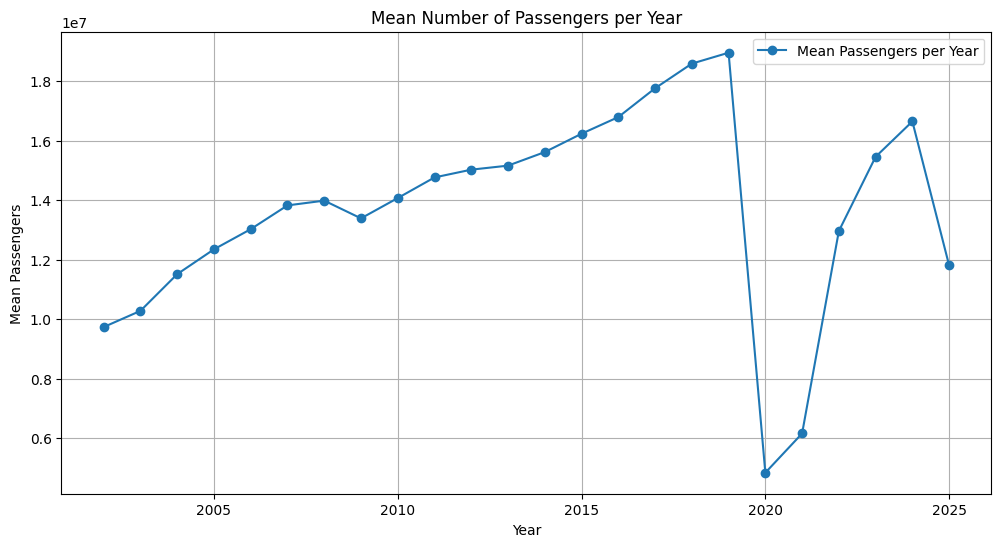

In [82]:
# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Group by year and calculate the mean for each year
yearly_means = total_passengers.resample('Y').mean()

# Convert the index to just the year for cleaner display
yearly_means.index = yearly_means.index.year

# Print the mean passengers per year
print("Mean Passengers per Year:")
print(yearly_means)

# Plot the mean passengers per year
plt.figure(figsize=(12, 6))
plt.plot(yearly_means.index, yearly_means, marker='o', label='Mean Passengers per Year')
plt.title('Mean Number of Passengers per Year')
plt.xlabel('Year')
plt.ylabel('Mean Passengers')
plt.grid(True)
plt.legend()
plt.show()

# Call the model and testing. Along with results here

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


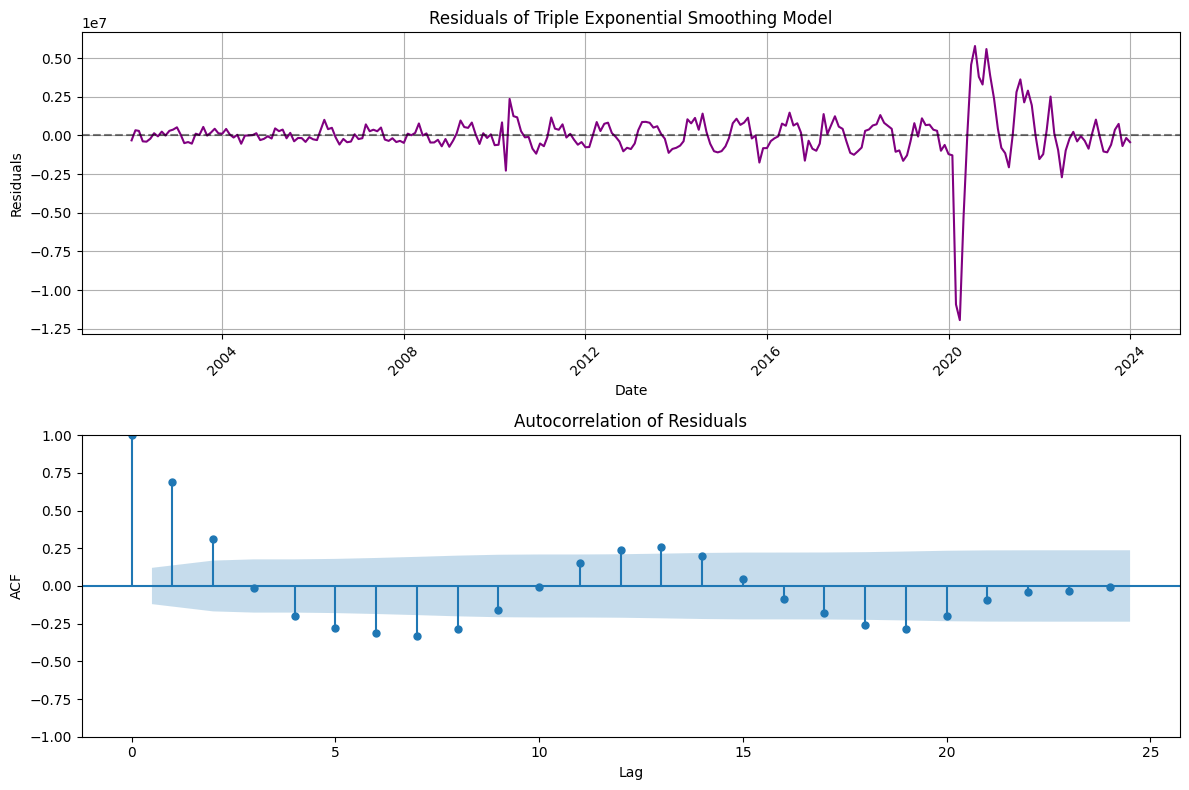

Ljung-Box Test Results:
       lb_stat     lb_pvalue
12  295.046093  5.146863e-56


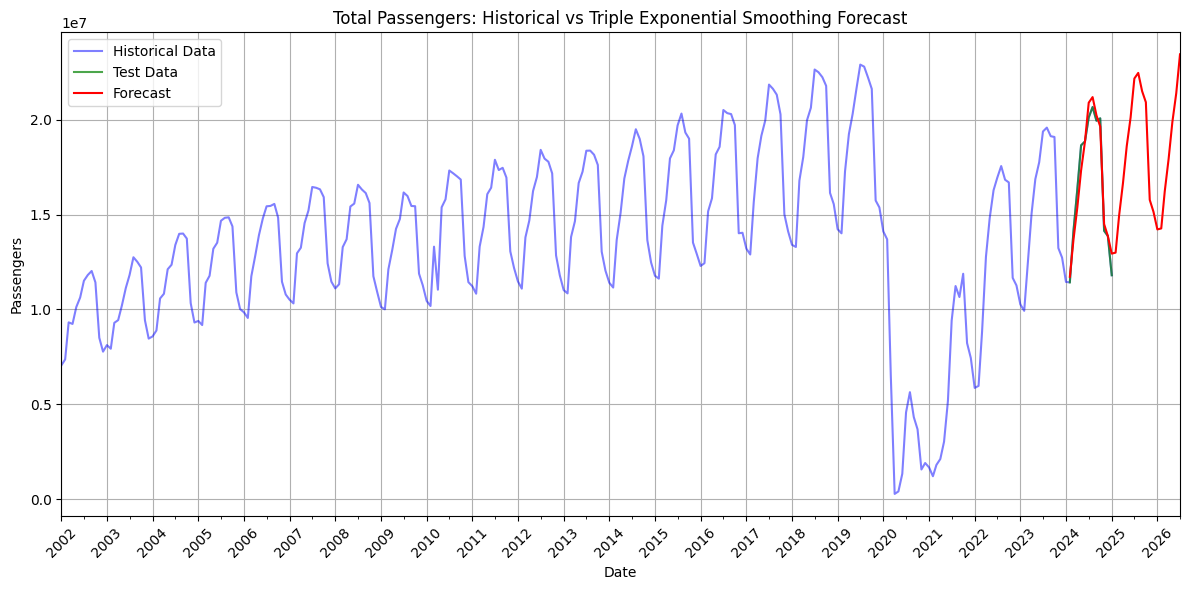

Train end date: 2024-01-01 00:00:00
Test data values: [11426285 14130802 16353547 18653005 18858441 20121631 20671829 19947957
 20074786 14147115 13874296 11803557]
Forecast values for test period: 2024-02-01    1.171990e+07
2024-03-01    1.367289e+07
2024-04-01    1.538775e+07
2024-05-01    1.733212e+07
2024-06-01    1.884931e+07
2024-07-01    2.089993e+07
2024-08-01    2.119505e+07
2024-09-01    2.023172e+07
2024-10-01    1.964849e+07
2024-11-01    1.450202e+07
2024-12-01    1.387004e+07
2025-01-01    1.294336e+07
Freq: MS, dtype: float64
MAE on test set: 546490.303922424


In [131]:
# Split into train and test (12 months for testing)
train_end = total_passengers.index[-13]
train_data = total_passengers[total_passengers.index <= train_end]
test_data = total_passengers[total_passengers.index > train_end]

# Define the seasonal period (12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing with multiplicative components
model = ExponentialSmoothing(
    train_data,
    seasonal_periods=seasonal_periods,
    trend='additive',
    seasonal='additive',
    initialization_method='heuristic'
)

# Fit the model with tuned parameters
fit_model = model.fit(smoothing_level=0.51, smoothing_trend=0.15, smoothing_seasonal=0.17)

# Forecast the next 31 periods
forecast = fit_model.forecast(31)

# Create a date range for the forecast
future_dates = pd.date_range(start=train_end, periods=31, freq='MS')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Calculate residuals for training data
fitted_values = fit_model.fittedvalues
residuals = train_data - fitted_values

# Plot residuals and ACF
plt.figure(figsize=(12, 8))

# Residuals plot
plt.subplot(2, 1, 1)
plt.plot(residuals.index, residuals, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Residuals of Triple Exponential Smoothing Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)
plt.grid(True)

# ACF plot
plt.subplot(2, 1, 2)
plot_acf(residuals, ax=plt.gca(), lags=24)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')

plt.tight_layout()
plt.show()

# Ljung-Box test for white noise
ljung_box_results = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

# Plot the original data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data, label='Test Data', color='green', alpha=0.7)
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')
plt.xlim(total_passengers.index[0], future_dates[-1])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate and print MAE
mae = mean_absolute_error(test_data, forecast[:len(test_data)])
print("Train end date:", train_end)
print("Test data values:", test_data.values)
print("Forecast values for test period:", forecast[:len(test_data)])
print("MAE on test set:", mae)

In [132]:
mae = mean_absolute_error(test_data, forecast[:len(test_data)])
rmse = root_mean_squared_error(test_data, forecast[:len(test_data)])
mape = mean_absolute_percentage_error(test_data, forecast[:len(test_data)]) * 100

print("MAE on test set:", mae)
print("RMSE on test set:", rmse)
print("MAPE on test set (%):", mape)

MAE on test set: 546490.303922424
RMSE on test set: 679482.2476276075
MAPE on test set (%): 3.4155482464260873


c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


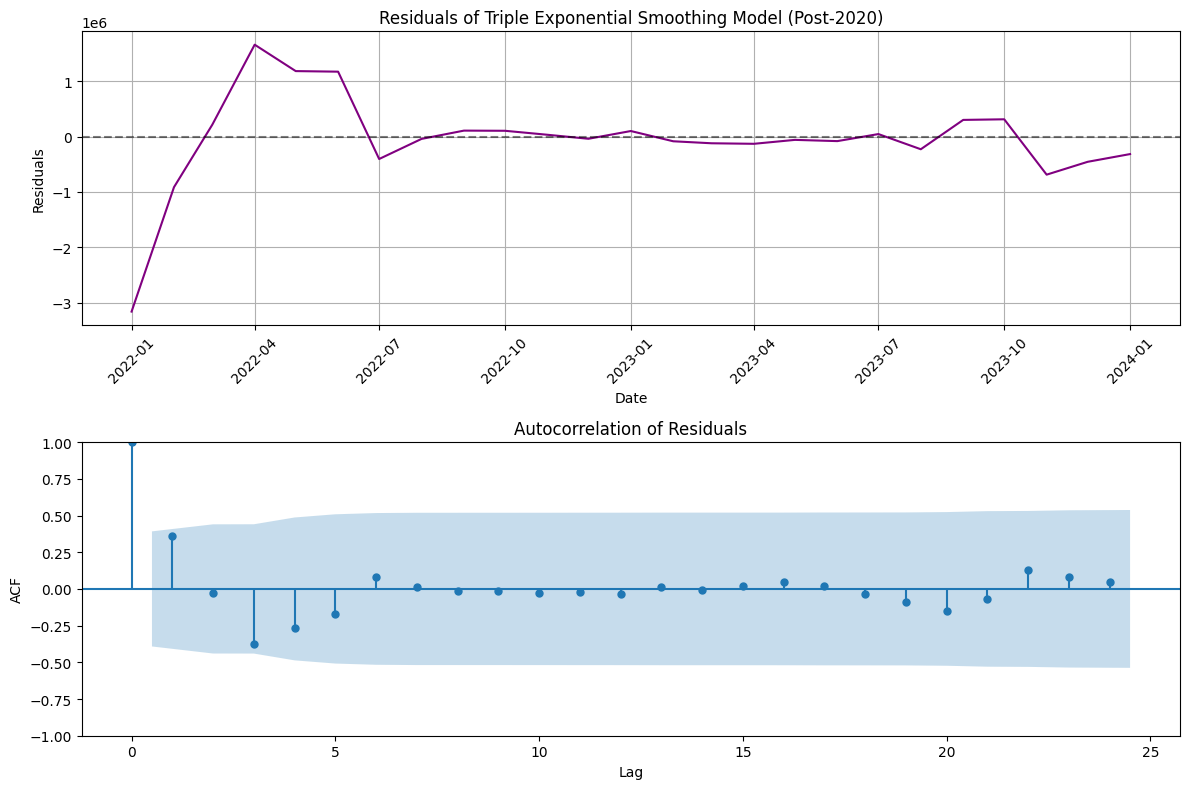

Ljung-Box Test Results:
      lb_stat  lb_pvalue
12  11.569032   0.480881


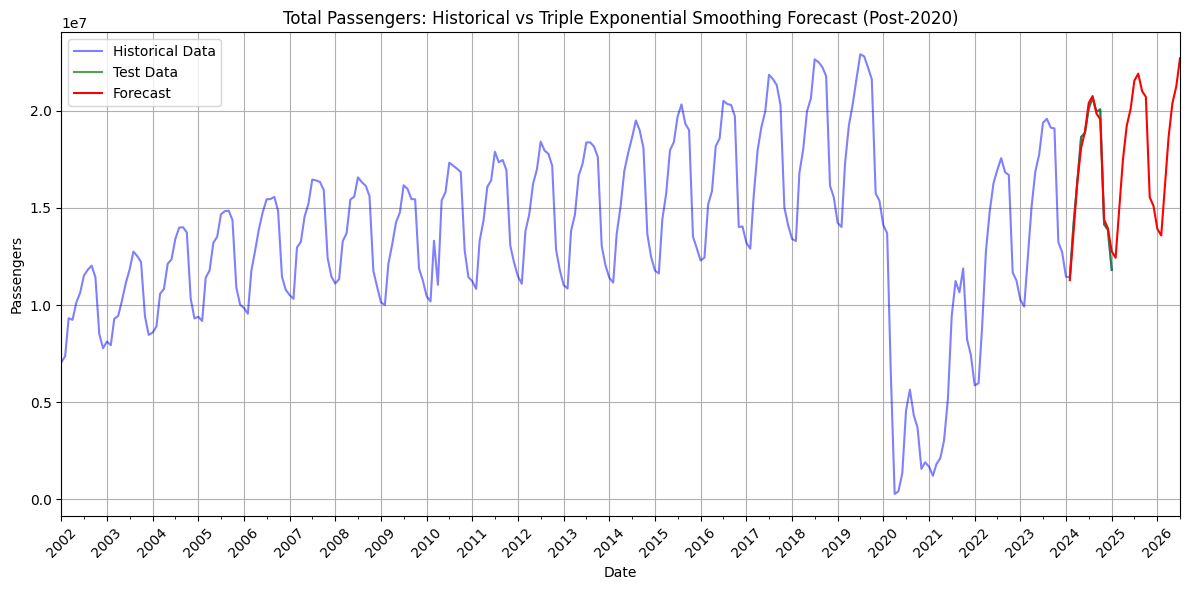

Train start date: 2022-01-01 00:00:00
Train end date: 2024-01-01 00:00:00
Test data values: [11426285 14130802 16353547 18653005 18858441 20121631 20671829 19947957
 20074786 14147115 13874296 11803557]
Forecast values for test period: 2024-02-01    1.128011e+07
2024-03-01    1.370855e+07
2024-04-01    1.635715e+07
2024-05-01    1.807796e+07
2024-06-01    1.893779e+07
2024-07-01    2.039960e+07
2024-08-01    2.075953e+07
2024-09-01    1.985512e+07
2024-10-01    1.956603e+07
2024-11-01    1.439431e+07
2024-12-01    1.395375e+07
2025-01-01    1.276160e+07
Freq: MS, dtype: float64
MAE on test set: 289866.241853291


In [113]:
# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Define post-COVID-19 training start (e.g., January 2021)
train_start = pd.to_datetime('2022-01-01')
train_end = total_passengers.index[-13]  # 12 months before the end for testing
train_data = total_passengers[(total_passengers.index >= train_start) & (total_passengers.index <= train_end)]
test_data = total_passengers[total_passengers.index > train_end]

# Define the seasonal period (12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing with multiplicative components
model = ExponentialSmoothing(
    train_data,
    seasonal_periods=seasonal_periods,
    trend='additive',
    seasonal='additive',
    initialization_method='heuristic'
)

# Fit the model with tuned parameters
# fit_model = model.fit(smoothing_level=0.55, smoothing_trend=0.2, smoothing_seasonal=0.05)
fit_model = model.fit(smoothing_level=0.5, smoothing_trend=0.15, smoothing_seasonal=0.05)
# Forecast the next 31 periods
forecast = fit_model.forecast(31)

# Create a date range for the forecast
future_dates = pd.date_range(start=train_end, periods=31, freq='MS')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Calculate residuals for training data
fitted_values = fit_model.fittedvalues
residuals = train_data - fitted_values

# Plot residuals and ACF
plt.figure(figsize=(12, 8))

# Residuals plot
plt.subplot(2, 1, 1)
plt.plot(residuals.index, residuals, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Residuals of Triple Exponential Smoothing Model (Post-2020)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)
plt.grid(True)

# ACF plot
plt.subplot(2, 1, 2)
plot_acf(residuals, ax=plt.gca(), lags=24)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')

plt.tight_layout()
plt.show()

# Ljung-Box test for white noise
ljung_box_results = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

# Plot the original data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data, label='Test Data', color='green', alpha=0.7)
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')
plt.xlim(total_passengers.index[0], future_dates[-1])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast (Post-2020)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate and print MAE
mae = mean_absolute_error(test_data, forecast[:len(test_data)])
print("Train start date:", train_start)
print("Train end date:", train_end)
print("Test data values:", test_data.values)
print("Forecast values for test period:", forecast[:len(test_data)])
print("MAE on test set:", mae)

# Jarque-Bera Test

## Null and Alternative Hypotheses
* Null Hypothesis (H₀): The residuals are normally distributed (their shape matches a bell curve).
* Alternative Hypothesis (H₁): The residuals are not normally distributed (they’re skewed or have unusual peaks).

### Finding: p is not less than 0.05 so we reject the null hypothesis. The model's residual is not normally distributed but that the other residual test shows that the model's errors are random using Ljung test.

In [114]:
# Jarque-Bera test for normality
jb_test = jarque_bera(residuals)
print("Jarque-Bera Test Results:")
print(f"Statistic: {jb_test[0]}, p-value: {jb_test[1]}, Skew: {jb_test[2]}, Kurtosis: {jb_test[3]}")

Jarque-Bera Test Results:
Statistic: 42.09824649694554, p-value: 7.219081158696883e-10, Skew: -1.4792258544988763, Kurtosis: 8.626889027037587


In [124]:
mae = mean_absolute_error(test_data, forecast[:len(test_data)])
rmse = root_mean_squared_error(test_data, forecast[:len(test_data)])
mape = mean_absolute_percentage_error(test_data, forecast[:len(test_data)]) * 100

print("MAE on test set:", mae)
print("RMSE on test set:", rmse)
print("MAPE on test set (%):", mape)

MAE on test set: 289866.241853291
RMSE on test set: 395213.7089772493
MAPE on test set (%): 1.919595986759393


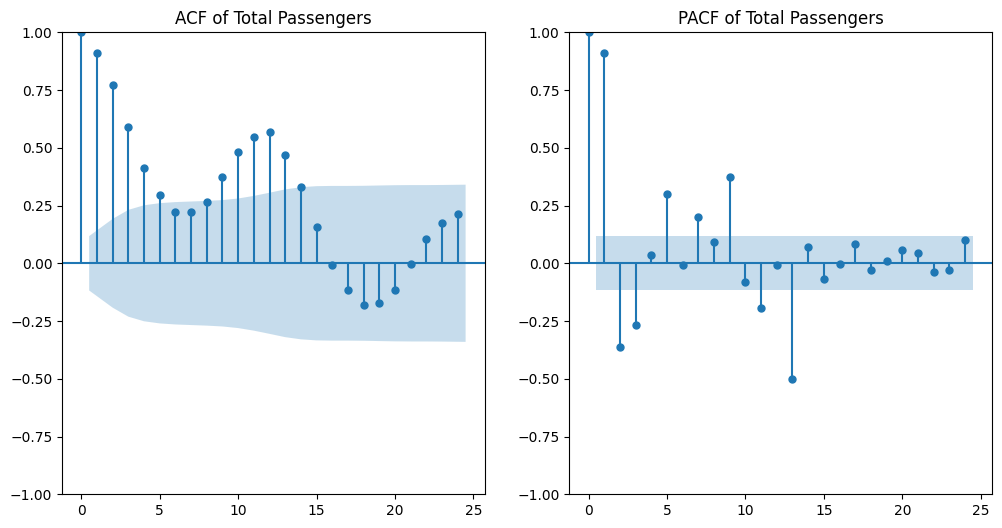

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(total_passengers, lags=24, ax=plt.gca())
plt.title('ACF of Total Passengers')
plt.subplot(1, 2, 2)
plot_pacf(total_passengers, lags=24, ax=plt.gca())
plt.title('PACF of Total Passengers')
plt.show()

In [88]:
# ob_cleaned.head()

In [89]:
# ob_cleaned.tail(20)

In [90]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.stats.diagnostic import acorr_ljungbox

# # Extract Total_Passengers as a time series
# total_passengers = ob_cleaned['Total_Passengers']

# # Impute 2020 data with linear interpolation
# total_passengers_imputed = total_passengers.copy()
# mask_2020 = (total_passengers.index.year == 2020)
# total_passengers_imputed[mask_2020] = total_passengers_imputed.interpolate(method='linear')[mask_2020]

# # Split into train and test (12 months for testing, train from 2002 with imputed 2020)
# train_end = total_passengers_imputed.index[-13]
# train_data = total_passengers_imputed[total_passengers_imputed.index <= train_end]
# test_data = total_passengers_imputed[total_passengers_imputed.index > train_end]

# # Define the seasonal period
# seasonal_periods = 12

# # Apply Triple Exponential Smoothing
# model = ExponentialSmoothing(
#     train_data,
#     seasonal_periods=seasonal_periods,
#     trend='mul',
#     seasonal='mul',
#     initialization_method='heuristic'
# )

# # Fit with current best parameters
# fit_model = model.fit(smoothing_level=0.55, smoothing_trend=0.15, smoothing_seasonal=0.05)

# # Forecast the next 31 periods
# forecast = fit_model.forecast(31)

# # Create a date range for the forecast
# future_dates = pd.date_range(start=train_end, periods=31, freq='MS')

# # Create a DataFrame for the forecast
# forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# # Calculate residuals
# fitted_values = fit_model.fittedvalues
# residuals = train_data - fitted_values

# # Plot residuals and ACF
# plt.figure(figsize=(12, 8))
# plt.subplot(2, 1, 1)
# plt.plot(residuals.index, residuals, label='Residuals', color='purple')
# plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
# plt.title('Residuals of Triple Exponential Smoothing Model (2002-2023 with 2020 Imputed)')
# plt.xlabel('Date')
# plt.ylabel('Residuals')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.subplot(2, 1, 2)
# plot_acf(residuals, ax=plt.gca(), lags=24)
# plt.title('Autocorrelation of Residuals')
# plt.xlabel('Lag')
# plt.ylabel('ACF')
# plt.tight_layout()
# plt.show()

# # Ljung-Box test
# ljung_box_results = acorr_ljungbox(residuals, lags=[12], return_df=True)
# print("Ljung-Box Test Results:")
# print(ljung_box_results)

# # Plot the original data, test data, and forecast
# plt.figure(figsize=(12, 6))
# plt.plot(total_passengers_imputed.index, total_passengers_imputed, label='Historical Data (Imputed)', color='blue', alpha=0.5)
# plt.plot(test_data.index, test_data, label='Test Data', color='green', alpha=0.7)
# plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')
# plt.xlim(total_passengers_imputed.index[0], future_dates[-1])
# plt.ylim(0, 3e7)
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())

In [100]:
# Mean number of passengers

total_passengers_no_2020 = total_passengers.mean()
print("Mean number of passengers: ", total_passengers_no_2020, " (13 million)")

Mean number of passengers:  13777159.758122744  (13 million)
